# Load libraries

In [1]:
#This notebook was run in the conda environment named "Jacob_Env1" (provided on GitHub)

In [2]:
#You are currently looking at the notebook processing/plotting the major cell types
cell_type = 'All'

In [3]:
#Load the required packages
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import pandas as pd
import numpy as np
import sys
import seaborn as sbn
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import bbknn
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator
import matplotlib.font_manager as fm

In [4]:
#Set paths
path = '/mnt/c/Users/User/Jacob-et-al'

In [5]:
#Load gene list required for cell cycle scoring
cell_cycle_genes_path = os.path.join(path,'Notebook-Input','regev_lab_cell_cycle_genes.txt')
cell_cycle_genes = [x.strip().title() for x in open(cell_cycle_genes_path)]

# Separate dataset for S-phase or G2M-phase associated genes
s_genes = [x for x in cell_cycle_genes[:43]]
g2m_genes = [x for x in cell_cycle_genes[43:]]

In [6]:
sc.logging.print_header()

scanpy==1.4.6 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.1 scikit-learn==0.23.2 statsmodels==0.12.0rc0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.0


In [7]:
#Define function to generate a plot with multiple subplots
def initialize_subplots(groups_to_plot, ncols = 3, figsize_multiplier = (7,5), gridspec_kw = None, figsize = None, print_help = True, **fig_kw):
    if type(groups_to_plot)==list:
        total = len(groups_to_plot)
    else:
        total = groups_to_plot
    nrows = int(np.ceil(total/ncols))
    if not figsize:
        figsize = (figsize_multiplier[0]*ncols, figsize_multiplier[1]*nrows)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize, gridspec_kw = gridspec_kw, **fig_kw)
    if print_help:
        if nrows>1 and ncols>1:
            print('ax = axes[ix // ncols, ix % ncols]')
        else:
            print('ax = axes[ix]')
    return fig, axes

# Import data

In [8]:
#Import scaled expression data (preprocessing was done with Seurat in R)
adata = sc.read_csv(os.path.join(path, 'Notebook-Input','{}_ScaledData.csv'.format(cell_type))).transpose()

In [9]:
adata

AnnData object with n_obs × n_vars = 32366 × 20001

## Import metadata

In [10]:
#Import additional metadata (preprocessing was done with Seurat in R)
metadata = pd.read_csv(os.path.join(path, 'Notebook-Input', '{}_MetaData.csv'.format(cell_type)), index_col = 0)
metadata_extension = pd.read_csv(os.path.join(path, 'Notebook-Input','QC_features.csv'),index_col='Unnamed: 0')
HVGs = pd.read_csv(os.path.join(path, 'Notebook-Input', '{}_ListHVG.csv'.format(cell_type)), sep = ';', index_col = 0) 
keratfibdoublets = pd.read_csv(os.path.join(path, 'Notebook-Input', 'Excluded-Doublets-1.csv'), index_col = 0, sep = ';')
keratlowquality = pd.read_csv(os.path.join(path, 'Notebook-Input', 'Excluded-LowQuality.csv'), index_col = 0, sep = ';')
#Import additional metadata generated in Scanpy; Note that pericyte/fibroblast doublets were identified in a subsequent step of this notebook; So, the notebook was run once util step 4 with these cells; then it turned out they have to be removed so we now load a list of these cells upfront to run the analysis without them
pericytefibdoublets = pd.read_csv(os.path.join(path, 'Notebook-Input', 'Excluded-Doublets-2.csv'), sep = ',')

## Assign metadata and remove doublets

In [11]:
#Add metadata to Scanpy's adata object
for feature in metadata_extension.columns:
    if feature not in metadata.columns:
        metadata[feature]=metadata_extension[feature]
    else:
        continue 
    
adata.obs = metadata.loc[adata.obs_names]

In [12]:
#Reuse highly variable genes which were determined with Seurat in R
adata.var['highly_variable'] = [True if x in HVGs.index else False for x in adata.var_names]

In [13]:
# Change all 'HC' columns (hierarchical clustering) to categorical for better plotting results
for col in [x for x in adata.obs.columns if 'HC' in x]:
    adata.obs[col] = adata.obs[col].astype('category')

In [14]:
#Original adata object has 32366 cells and 20001 genes
adata

AnnData object with n_obs × n_vars = 32366 × 20001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'simp_index', 'invsimp_index', 'shan_index', 'perc_rpl', 'perc_rps', 'perc_hb.ab.', 'perc_mito', 'perc_hba', 'perc_hbb', 'perc_hist', 'filtered', 'sample_id', 'embryonic_age', 'genotype', 'dataset', 'sample_no', 'sample_code', 'sample_date', 'library', 'sequencing', 'sex', 'S.Score', 'G2M.Score', 'Phase', 'G1.Score', 'CC.Diff', 'HC_1', 'HC_2', 'HC_3', 'HC_4', 'HC_5', 'HC_6', 'HC_7', 'HC_8', 'HC_9', 'HC_10', 'HC_11', 'HC_12', 'HC_13', 'HC_14', 'HC_15', 'HC_16', 'HC_17', 'HC_18', 'HC_19', 'HC_20', 'HC_21', 'HC_22', 'HC_23', 'HC_24', 'HC_25', 'HC_26', 'HC_27', 'HC_28', 'HC_30', 'HC_31', 'HC_33', 'HC_35', 'HC_37', 'HC_39', 'HC_42', 'HC_45', 'HC_49', 'HC_53', 'HC_58', 'HC_64', 'HC_72', 'HC_82', 'HC_95', 'HC_112', 'HC_138', 'HC_180', 'perc_protein_coding', 'perc_processed_pseudogene', 'perc_unknown', 'perc_Chr_1', 'perc_Chr_X', 'perc_Chr_Y'
    var: 'highly_variable'

In [15]:
#Remove Doublets (Keratinocytes/Fibroblasts). 54 cells are removed. See Methods section in publication.
adata = adata[[x for x in adata.obs_names if x not in keratfibdoublets.values]].copy()

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [16]:
#Remove Doublets (Pericyte/Fibroblasts). 30 cells are removed. See Methods section in publication.
adata = adata[[x for x in adata.obs_names if x not in pericytefibdoublets.columns.values]].copy()

In [17]:
#Remove low quality keratinocytes. 35 cells are removed. See Methods section in publication.
adata = adata[[x for x in adata.obs_names if x not in keratlowquality.values]].copy()

In [18]:
#Cleaned adata object has 32247 cells and 20001 genes
adata

AnnData object with n_obs × n_vars = 32247 × 20001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'simp_index', 'invsimp_index', 'shan_index', 'perc_rpl', 'perc_rps', 'perc_hb.ab.', 'perc_mito', 'perc_hba', 'perc_hbb', 'perc_hist', 'filtered', 'sample_id', 'embryonic_age', 'genotype', 'dataset', 'sample_no', 'sample_code', 'sample_date', 'library', 'sequencing', 'sex', 'S.Score', 'G2M.Score', 'Phase', 'G1.Score', 'CC.Diff', 'HC_1', 'HC_2', 'HC_3', 'HC_4', 'HC_5', 'HC_6', 'HC_7', 'HC_8', 'HC_9', 'HC_10', 'HC_11', 'HC_12', 'HC_13', 'HC_14', 'HC_15', 'HC_16', 'HC_17', 'HC_18', 'HC_19', 'HC_20', 'HC_21', 'HC_22', 'HC_23', 'HC_24', 'HC_25', 'HC_26', 'HC_27', 'HC_28', 'HC_30', 'HC_31', 'HC_33', 'HC_35', 'HC_37', 'HC_39', 'HC_42', 'HC_45', 'HC_49', 'HC_53', 'HC_58', 'HC_64', 'HC_72', 'HC_82', 'HC_95', 'HC_112', 'HC_138', 'HC_180', 'perc_protein_coding', 'perc_processed_pseudogene', 'perc_unknown', 'perc_Chr_1', 'perc_Chr_X', 'perc_Chr_Y'
    var: 'highly_variable'

## Correct gene names from old to approved version (scaled data)

In [19]:
symbol_names = pd.read_csv(os.path.join(path, 'Notebook-Input','Hgnc-symbol-check.csv'), header = 1, index_col = 0)['Approved symbol'].dropna()
symbol_names.loc[symbol_names.index[symbol_names.index.duplicated()]]

Input
Lnp         NUSAP1
Lnp           LNPK
Csrp2bp      KAT14
Csrp2bp     PET117
Agpat9      LPCAT1
Agpat9       GPAT3
Stra13       CENPX
Stra13     BHLHE40
PISD          PISD
PISD          SFI1
Name: Approved symbol, dtype: object

In [20]:
# Some genes had multiple corresponding new approved names in HUGO,thu we decided to remove the duplicated genes from adata
duplicated_genes = symbol_names.index[symbol_names.index.duplicated()]
adata = adata[:, [x for x in adata.var_names if x not in duplicated_genes]].copy()

In [21]:
# The number of total genes reduced from 20001 to 19996
adata

AnnData object with n_obs × n_vars = 32247 × 19996
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'simp_index', 'invsimp_index', 'shan_index', 'perc_rpl', 'perc_rps', 'perc_hb.ab.', 'perc_mito', 'perc_hba', 'perc_hbb', 'perc_hist', 'filtered', 'sample_id', 'embryonic_age', 'genotype', 'dataset', 'sample_no', 'sample_code', 'sample_date', 'library', 'sequencing', 'sex', 'S.Score', 'G2M.Score', 'Phase', 'G1.Score', 'CC.Diff', 'HC_1', 'HC_2', 'HC_3', 'HC_4', 'HC_5', 'HC_6', 'HC_7', 'HC_8', 'HC_9', 'HC_10', 'HC_11', 'HC_12', 'HC_13', 'HC_14', 'HC_15', 'HC_16', 'HC_17', 'HC_18', 'HC_19', 'HC_20', 'HC_21', 'HC_22', 'HC_23', 'HC_24', 'HC_25', 'HC_26', 'HC_27', 'HC_28', 'HC_30', 'HC_31', 'HC_33', 'HC_35', 'HC_37', 'HC_39', 'HC_42', 'HC_45', 'HC_49', 'HC_53', 'HC_58', 'HC_64', 'HC_72', 'HC_82', 'HC_95', 'HC_112', 'HC_138', 'HC_180', 'perc_protein_coding', 'perc_processed_pseudogene', 'perc_unknown', 'perc_Chr_1', 'perc_Chr_X', 'perc_Chr_Y'
    var: 'highly_variable'

In [22]:
# Replace gene names with the approved symbols
adata.var_names = [symbol_names.loc[x].capitalize() if x in symbol_names.index else x for x in adata.var_names]

In [23]:
#After renaming one gene name was not unique anymore ('Ric8b'; old name 'Ric8'). The gene was removed.
adata.var_names[adata.var.index.duplicated()]
adata = adata[:, [True if x!='Ric8b' else False for x in adata.var_names]].copy()

# Read in raw and normalized data to add to layers

In [24]:
raw_data = sc.read_csv(os.path.join(path, 'Notebook-Input','{}_RawData.csv'.format(cell_type))).transpose()
norm_data = sc.read_csv(os.path.join(path, 'Notebook-Input','{}_NormalizedData.csv'.format(cell_type))).transpose()

In [25]:
raw_data

AnnData object with n_obs × n_vars = 32366 × 20001

## Correct gene names from old to approved version (raw and normalized data)

In [26]:
raw_data = raw_data[:, [x for x in raw_data.var_names if x not in duplicated_genes]].copy()
norm_data = norm_data[:, [x for x in norm_data.var_names if x not in duplicated_genes]].copy()

In [27]:
# Replace gene names with the approved symbols
raw_data.var_names = [symbol_names.loc[x].capitalize() if x in symbol_names.index else x for x in raw_data.var_names]
norm_data.var_names = [symbol_names.loc[x].capitalize() if x in symbol_names.index else x for x in norm_data.var_names]

In [28]:
# Remove 'Ric8b' gene from adata because it was duplicated (old name 'Ric8')
raw_data = raw_data[:, [True if x!='Ric8b' else False for x in raw_data.var_names]].copy()
norm_data = norm_data[:, [True if x!='Ric8b' else False for x in norm_data.var_names]].copy()

## Assign raw and normalized data as layers in adata

In [29]:
adata.layers['raw'] = raw_data[adata.obs_names][:,adata.var_names].X
adata.layers['normalized'] = norm_data[adata.obs_names][:,adata.var_names].X

In [30]:
adata.layers

Layers with keys: raw, normalized

# Dimensionality Reduction

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'orig.ident' as categorical
... storing 'sample_id' as categorical
... storing 'embryonic_age' as categorical
... storing 'genotype' as categorical
... storing 'dataset' as categorical
... storing 'sample_code' as categorical
... storing 'sample_date' as categorical
... storing 'library' as categorical
... storing 'sequencing' as categorical
... storing 'sex' as categorical
... storing 'Phase' as categorical


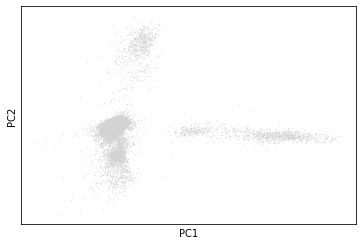

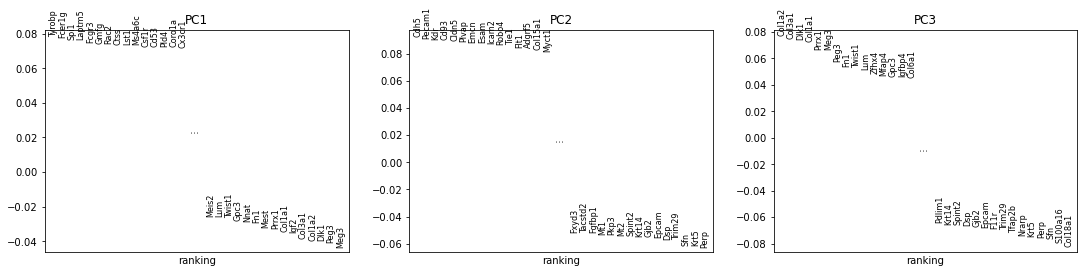

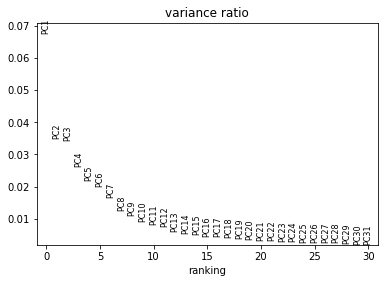

In [31]:
#Run PCA on scaled data from Seurat
sc.pp.pca(adata)
sc.pl.pca_overview(adata)

In [32]:
#Correct for batch effect from sampling date with the help of BBKNN
bbknn.bbknn(adata, batch_key = 'sample_date')

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


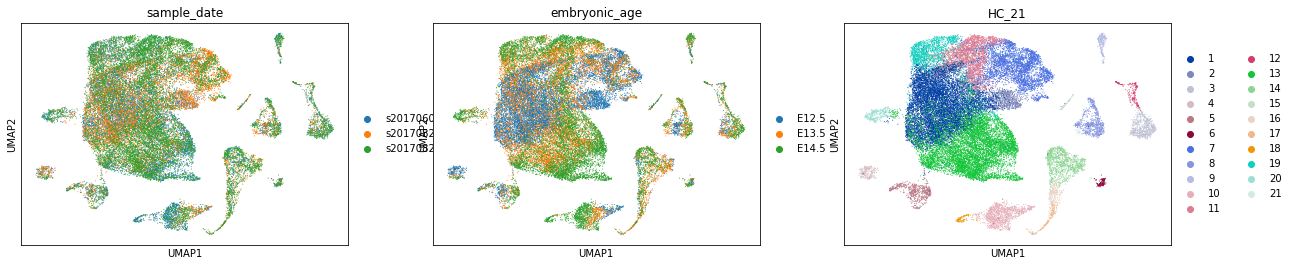

In [33]:
#Run UMAP and plot metadata from Seurat (incl. hierarchical clustering HC_21) onto UMAP
#Note: Additional metadata is available (e.g. read counts, percentage of mitochondrial reads, etc.). Check adata.obs
#Note: We decided to work with the clustering HC_21. However additional hierarchical clustering results (run with different resolutions) can be accessed via adata.obs
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['sample_date', 'embryonic_age', 'HC_21'])

In [34]:
#Rename clusters from HC_21 according to major cell types that cells were assigned to
naming_dict = {1:'FIB',2:'FIB',7:'FIB',11:'FIB',13:'FIB',19:'FIB',10: 'EPI',18: 'EPI', 4: 'EPI', 15: 'VESSEL LECs', 5: 'VESSEL BECs', 20: 'VESSEL MuralCells', 14: 'MUSCLE Early', 16: 'MUSCLE Mid', 17: 'MUSCLE Late', 3: 'IMMU Macrophages', 9: 'IMMU MastCells', 12: 'IMMU DendriticCells',8: 'NC SchwannCells', 6: 'NC Melanocytes', 21: 'NC Neurons'}
adata.obs['HC_named'] = [naming_dict[x] for x in adata.obs['HC_21']]

In [35]:
#Remove neuronal cells (cluster 21). See Methods section in publication.
adata = adata[~adata.obs['HC_21'].isin([21])].copy()

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'HC_named' as categorical


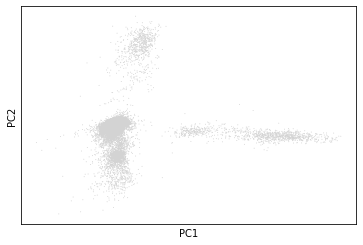

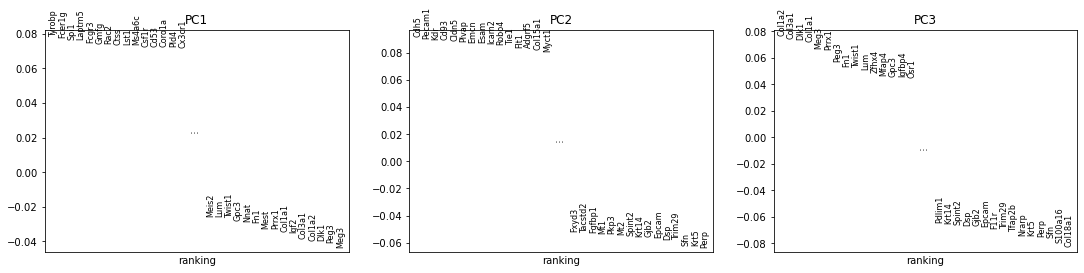

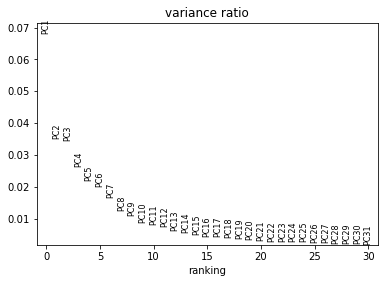

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [36]:
#Rerun PCA, BBKNN and UMAP without neuronal cells
sc.pp.pca(adata)
sc.pl.pca_overview(adata)
bbknn.bbknn(adata, batch_key = 'sample_date')
sc.tl.umap(adata)

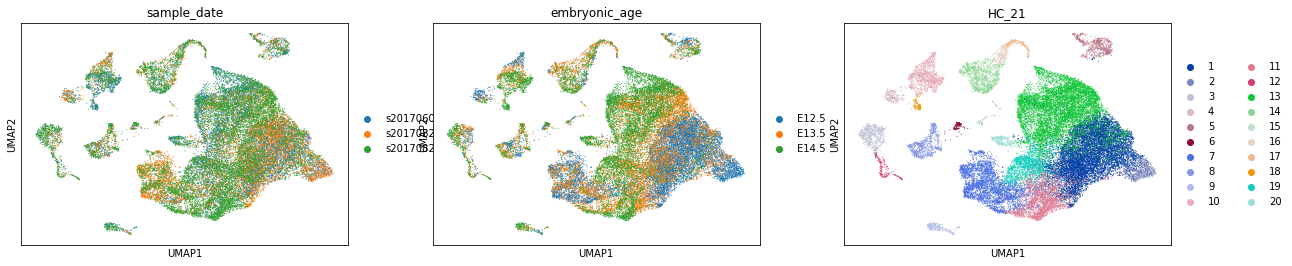

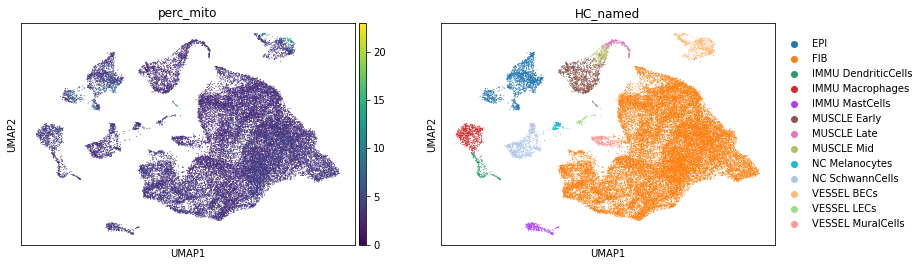

In [37]:
sc.pl.umap(adata, color = ['sample_date', 'embryonic_age', 'HC_21'])
sc.pl.umap(adata, color = ['perc_mito', 'HC_named'])

In [38]:
#Show order of clusters in adata object
adata.obs['HC_named'].cat.categories

Index(['EPI', 'FIB', 'IMMU DendriticCells', 'IMMU Macrophages',
       'IMMU MastCells', 'MUSCLE Early', 'MUSCLE Late', 'MUSCLE Mid',
       'NC Melanocytes', 'NC SchwannCells', 'VESSEL BECs', 'VESSEL LECs',
       'VESSEL MuralCells'],
      dtype='object')

In [39]:
#Assign new colors to clusters
adata.uns['HC_named_colors']=['#47D147', '#666699', '#B3D1Ff', '#1A75FF', '#0047B3', '#29A3A3', '#ADEBEB', '#47D1D1', '#FF6666', '#FF8c1A', '#DB70B8' , '#B82E8A', '#551F8B'] # Previous Mural Cell Color #9900E6 

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

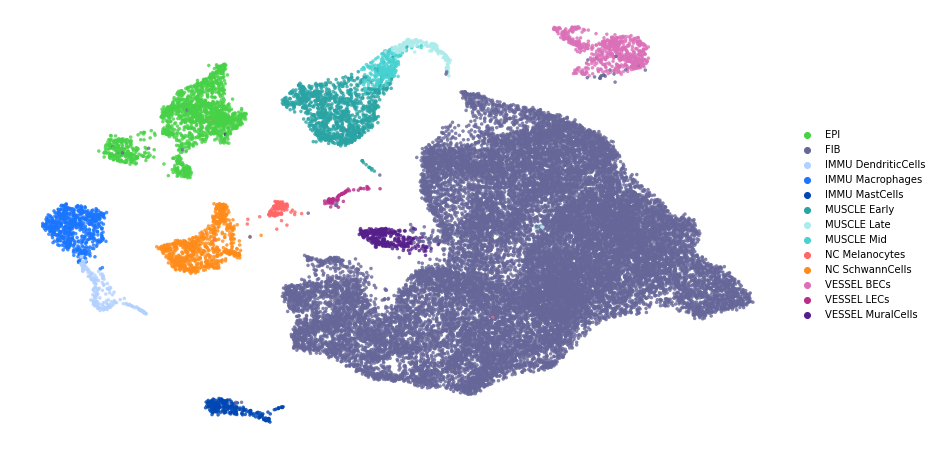

In [40]:
#Plot UMAP with cluster names and correct cluster colors
mult = 2
fig, ax = plt.subplots(figsize = (7*mult, 4*mult))
sc.pl.umap(adata, color = 'HC_named',  ax = ax, show = False, frameon = False, s = 50, title = '', alpha = 0.8)

# Save UMAP coordinates

In [41]:
pd.DataFrame(data = adata.obsm['X_umap'], index = adata.obs_names).to_csv(os.path.join(path, 'Notebook-Output', 'ALL_Umap-coordinates.csv'))

# Save clustering

In [42]:
#Save first Level Clustering (major cell types)
cluster_df_1st = pd.DataFrame()
cluster_df_1st['Clustering'] = adata.obs['HC_named']
cluster_df_1st.to_csv(os.path.join(path, 'Notebook-Output', 'All-Cells_1st-level-clustering.csv'))
cluster_df_1st

Clustering
AAACCTGAGACTTGAA_10x_17_033_12           FIB
AAACCTGAGAGTCTGG_10x_17_033_12           FIB
AAACCTGAGTATTGGA_10x_17_033_12           FIB
AAACCTGCACATCCAA_10x_17_033_12           FIB
AAACCTGCACCGATAT_10x_17_033_12           FIB
...                                      ...
TTTGGTTGTGAGCGAT_10x_17_051_14           FIB
TTTGTCAAGGGCACTA_10x_17_051_14           FIB
TTTGTCACAAGAGTCG_10x_17_051_14           FIB
TTTGTCACACAACGTT_10x_17_051_14  MUSCLE Early
TTTGTCAGTGGCTCCA_10x_17_051_14           FIB

[32194 rows x 1 columns]

# Plotting (Figure 1)

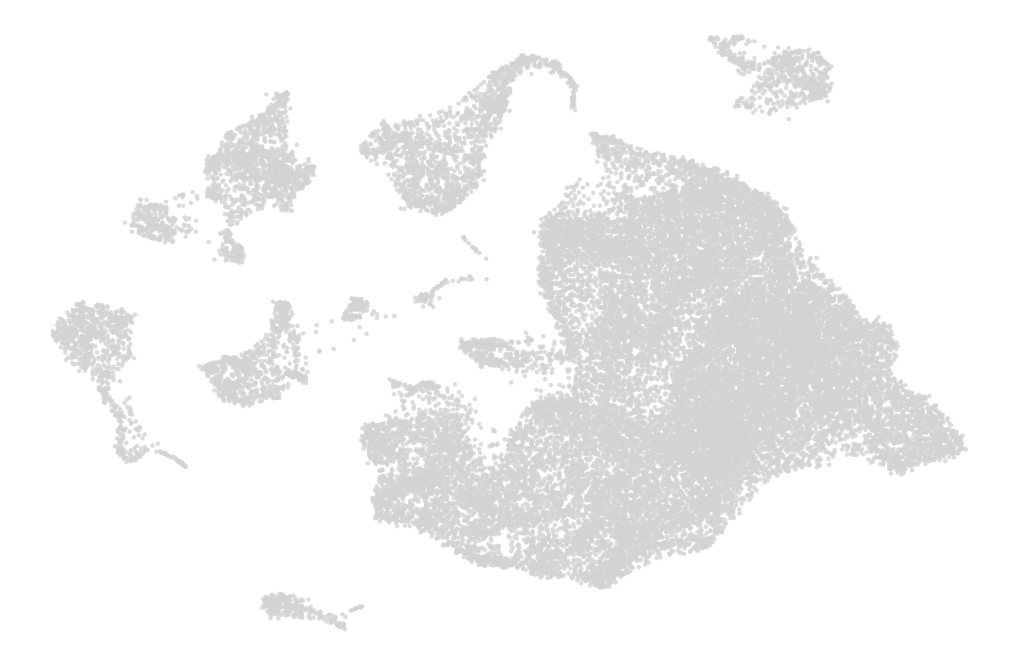

In [43]:
mult = 2
fig, ax = plt.subplots(figsize = (9*mult, 6*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 80, title = '', alpha = 0.8)
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_AllGray.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

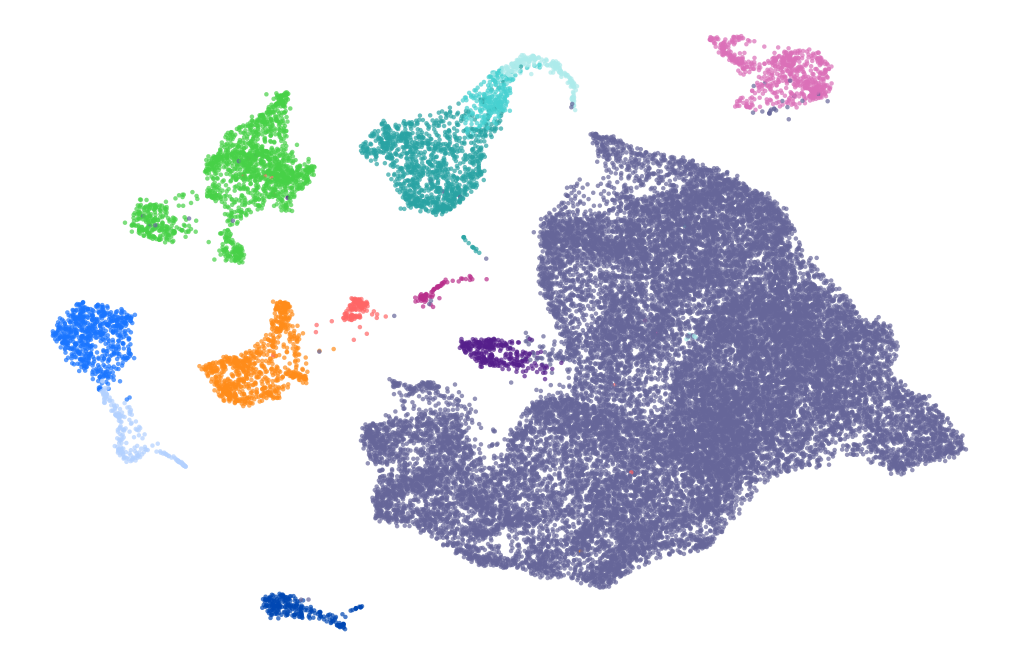

In [44]:
multiplier=2
fig, ax = plt.subplots(figsize = (9*multiplier, 6*multiplier))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 80, title = '', alpha = 0.7,color='HC_named')
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_clusters.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

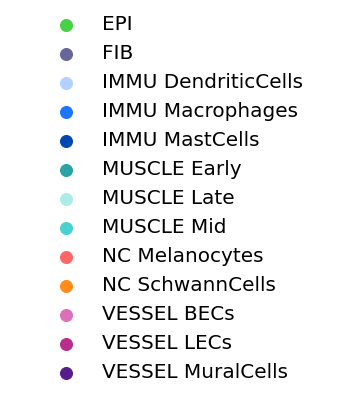

In [45]:
label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":20},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_clusters_legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

No handles with labels found to put in legend.


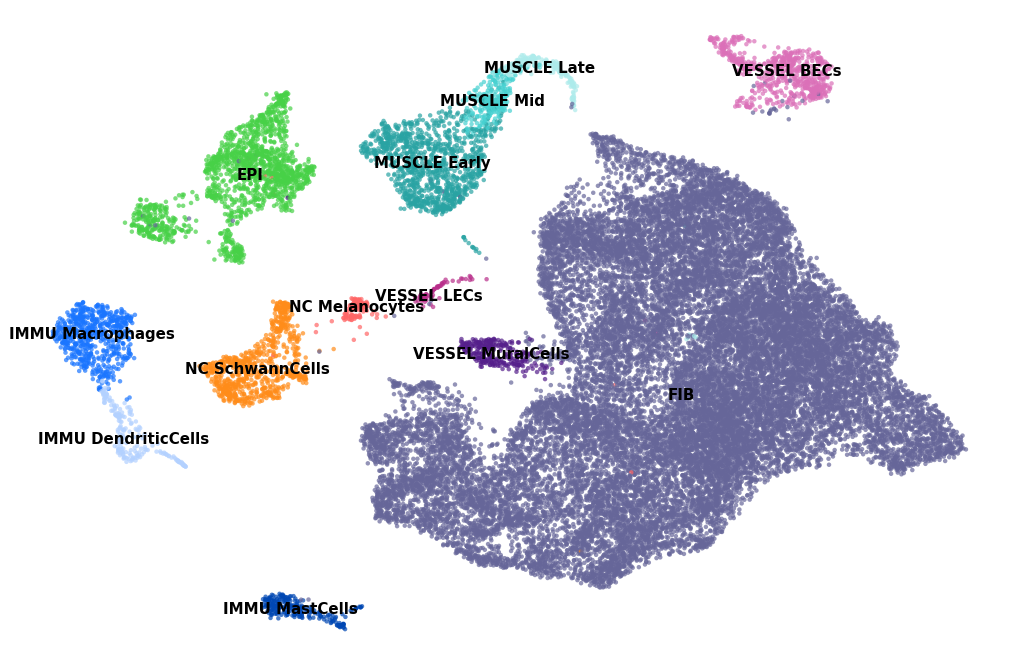

In [46]:
multiplier=2
fig, ax = plt.subplots(figsize = (9*multiplier, 6*multiplier))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 80, title = '', alpha = 0.7,color='HC_named',legend_loc='on data',legend_fontsize=15)
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_clusters-Legend-On-Data.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [47]:
#Assign colors to categorical variable 'embryonic age'
adata.uns['embryonic_age_colors']=['#E00D75','#85C100','#3399C1'] 

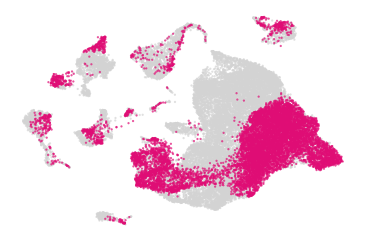

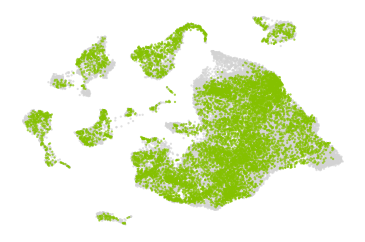

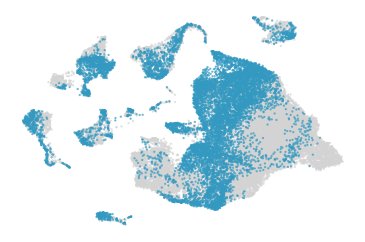

In [48]:
#Only highlight cells sampled at a specific embryonic age in color on top of a grey UMAP showing all cells
mult = 3
fig, ax = plt.subplots(figsize = (2.1*mult, 1.4*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 20, title = '', alpha = 0.7,color='embryonic_age', groups=['E12.5'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Age_E12.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

fig, ax = plt.subplots(figsize = (2.1*mult, 1.4*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 20, title = '', alpha = 0.7,color='embryonic_age', groups=['E13.5'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Age_E13.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

fig, ax = plt.subplots(figsize = (2.1*mult, 1.4*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 20, title = '', alpha = 0.7,color='embryonic_age', groups=['E14.5'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Age_E14.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [49]:
#Rename original sample names to plot samples on top of UMAP for quality control
naming_dict = {'1-12B':'E12.5 #1','1-12C':'E12.5 #2','1-14A':'E14.5 #1','1-14C':'E14.5 #2','2-12B':'E12.5 #3','2-12C':'E12.5 #4','2-12D':'E12.5 #5','2-13A':'E13.5 #1','2-13B':'E13.5 #2','3-13B':'E13.5 #3','3-13C':'E13.5 #4','3-13D':'E13.5 #5','3-14A':'E14.5 #3','3-14C':'E14.5 #4','3-14D':'E14.5 #5'}
adata.obs['samples_named'] = [naming_dict[x] for x in adata.obs['sample_code']]

In [50]:
#Asign new colors to original samples so they can be better distinguished on UMAP
adata.uns['samples_named_colors']=['#47D147', '#666699', '#29A3A3','#FF8c1A', '#DB70B8','#47D147', '#666699', '#29A3A3','#FF8c1A', '#DB70B8','#47D147', '#666699', '#29A3A3','#FF8c1A', '#DB70B8' ]

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'samples_named' as categorical


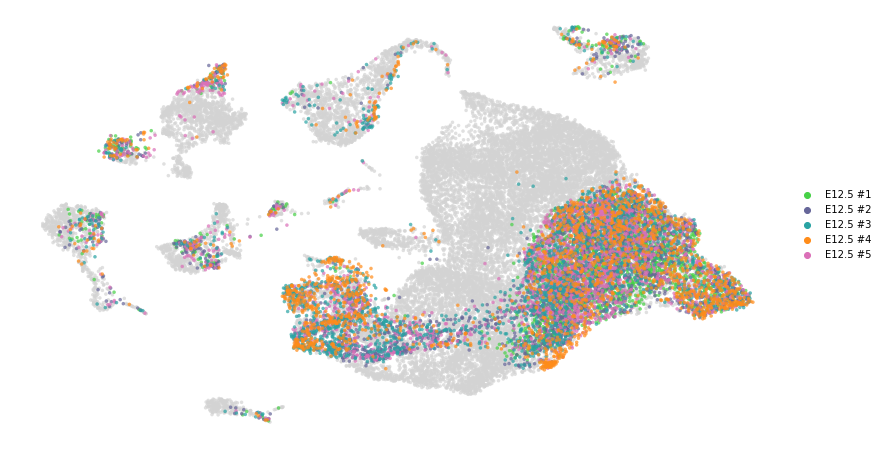

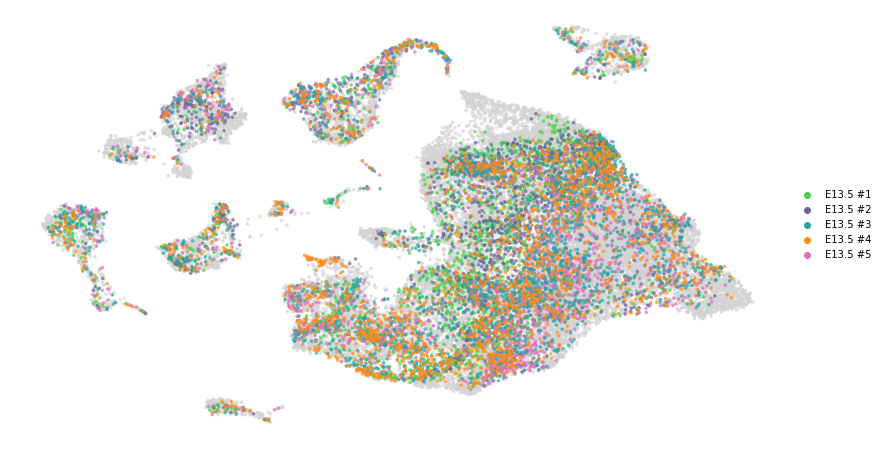

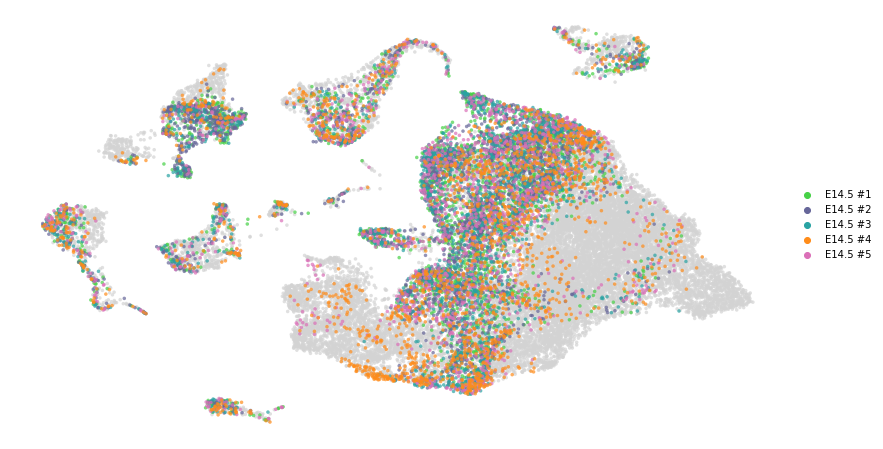

In [51]:
mult = 2
fig, ax = plt.subplots(figsize = (7*mult, 4*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 50, title = '', alpha = 0.7,color='samples_named', groups=['E12.5 #1','E12.5 #2','E12.5 #3','E12.5 #4','E12.5 #5'])
#ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Samples_E12.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

fig, ax = plt.subplots(figsize = (7*mult, 4*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 50, title = '', alpha = 0.7,color='samples_named', groups=['E13.5 #1','E13.5 #2','E13.5 #3','E13.5 #4','E13.5 #5'])
#ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Samples_E13.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

fig, ax = plt.subplots(figsize = (7*mult, 4*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 50, title = '', alpha = 0.7,color='samples_named', groups=['E14.5 #1','E14.5 #2','E14.5 #3','E14.5 #4','E14.5 #5'])
#ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Samples_E14.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [52]:
#Generate color bar for plotting gene expression levels on top of UMAP
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.8, 0.8, 0.8), (0.19, 0.04, 0.55)] # first color is grey, last is dark purple
cm = LinearSegmentedColormap.from_list("Custom", colors, N=200)

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

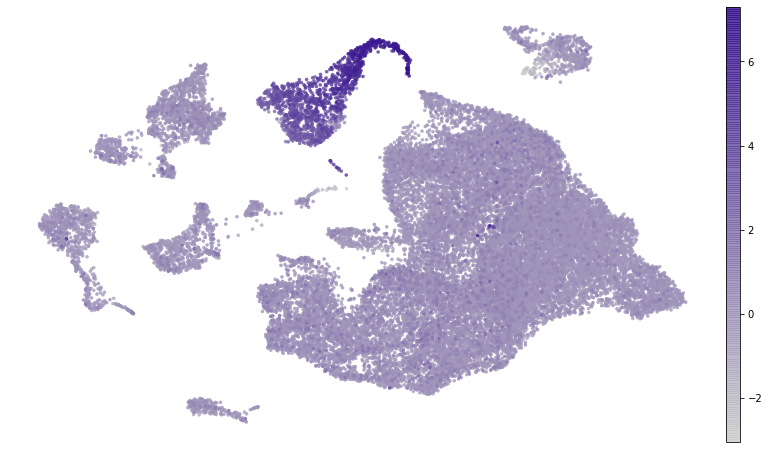

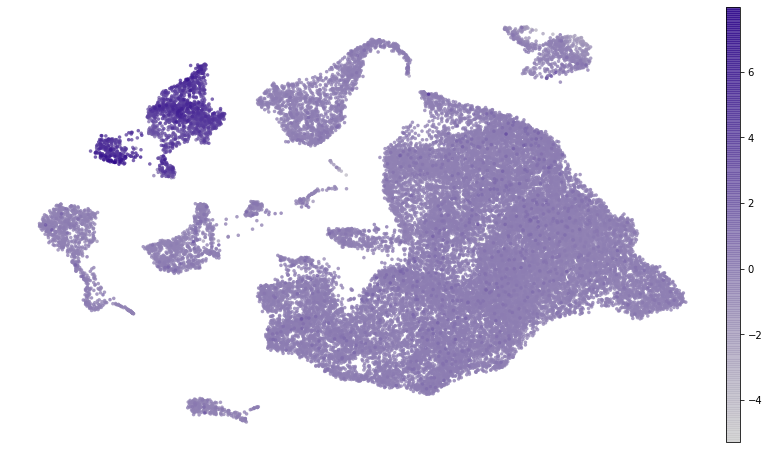

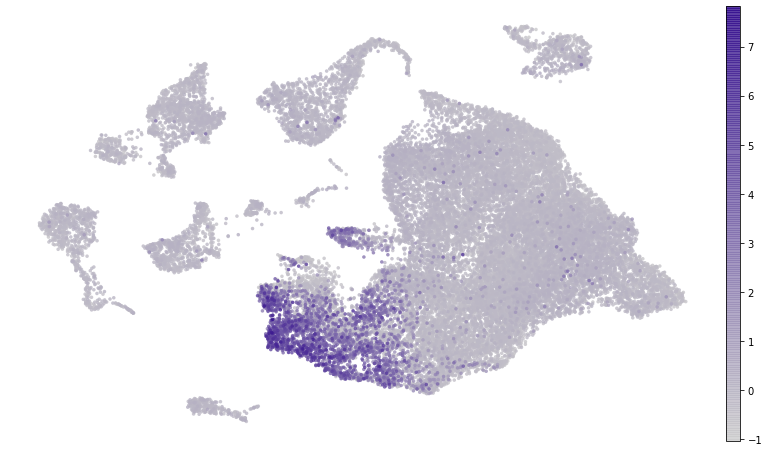

In [53]:
#Plotting a couple of example genes
mult = 2
fig, ax = plt.subplots(figsize = (7*mult, 4*mult))
sc.pl.umap(adata, color = ['Actc1'],  ax = ax, show = False, frameon = False, s = 50, title = '', alpha = 0.8,cmap=cm)

mult = 2
fig, ax = plt.subplots(figsize = (7*mult, 4*mult))
sc.pl.umap(adata, color = ['Krt5'],  ax = ax, show = False, frameon = False, s = 50, title = '', alpha = 0.8,cmap=cm)

mult = 2
fig, ax = plt.subplots(figsize = (7*mult, 4*mult))
sc.pl.umap(adata, color = ['Ebf2'],  ax = ax, show = False, frameon = False, s = 50, title = '', alpha = 0.8,cmap=cm)

In [54]:
#Generate color bar for plotting gene expression levels in DotPlot
colors = [(1,1,1), (0.19, 0.04, 0.55)] # first color is white, last is dark purple
cm = LinearSegmentedColormap.from_list("Custom", colors, N=200)

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


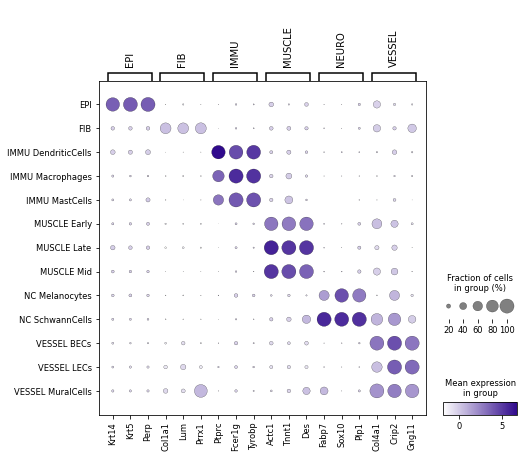

In [55]:
#Generate DotPlot to visualize markers setting apart the major cell types
marker_genes_dict = {'EPI': ['Krt14', 'Krt5','Perp'],
                     'FIB': ['Col1a1','Lum','Prrx1'],
                    'IMMU': ['Ptprc','Fcer1g','Tyrobp'],
                     'MUSCLE': ['Actc1','Tnnt1','Des'],
                     'NEURO': ['Fabp7','Sox10','Plp1'],
                     'VESSEL': ['Col4a1','Crip2','Gng11']}

mult=1.5
fig, ax = plt.subplots(figsize=(5*mult,5*mult))
sc.pl.dotplot(adata, marker_genes_dict, groupby='HC_named',dendrogram=False, ax=ax,show=False,cmap=cm)
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Dotplot_white.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [56]:
#Show number of cells per major cell type
adata.obs.groupby(["HC_named"]).apply(len)

HC_named
EPI                     1584
FIB                    25944
IMMU DendriticCells      200
IMMU Macrophages         664
IMMU MastCells           245
MUSCLE Early            1125
MUSCLE Late              209
MUSCLE Mid               262
NC Melanocytes           143
NC SchwannCells          795
VESSEL BECs              638
VESSEL LECs               79
VESSEL MuralCells        306
dtype: int64

In [57]:
#Show number of cells per embryonic age
adata.obs.groupby(["embryonic_age"]).apply(len)

embryonic_age
E12.5    11280
E13.5     9964
E14.5    10950
dtype: int64

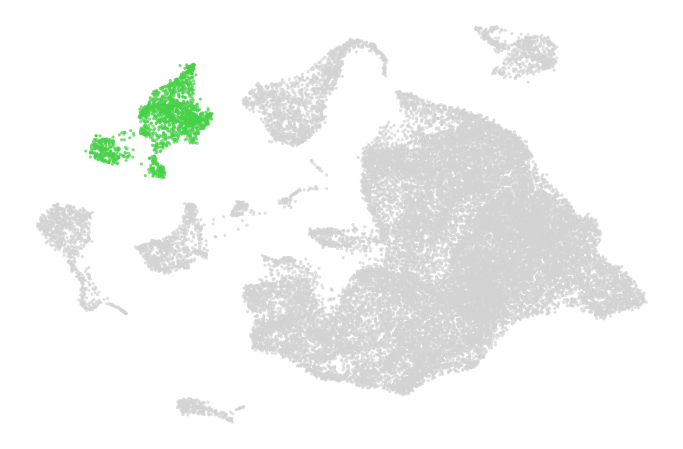

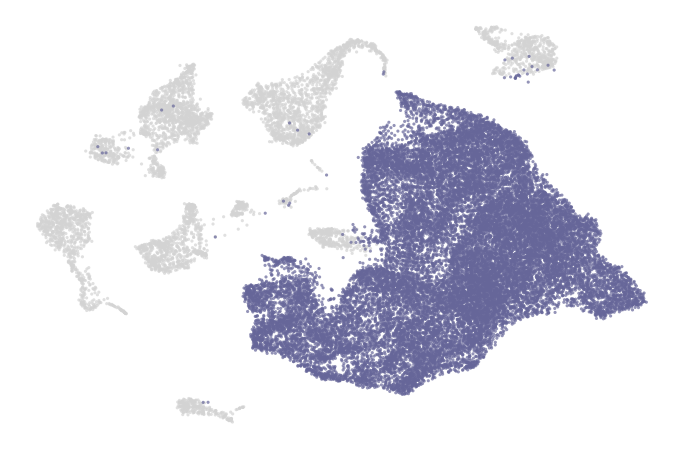

In [58]:
#Highlight Keratinocytes and Fibroblasts on top of UMAP
multiplier=2

fig, ax = plt.subplots(figsize = (6*multiplier, 4*multiplier))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 40, title = '', alpha = 0.7,color='HC_named',groups=['EPI'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Epi.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

fig, ax = plt.subplots(figsize = (6*multiplier, 4*multiplier))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 40, title = '', alpha = 0.7,color='HC_named',groups=['FIB'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Fib.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

# Plotting (Figure 6)

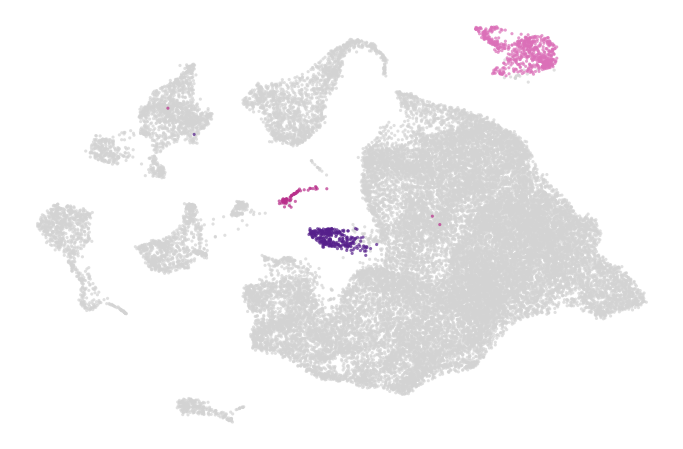

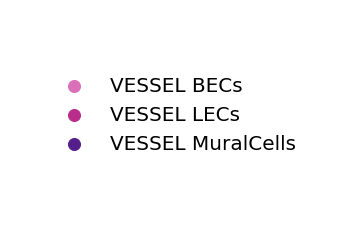

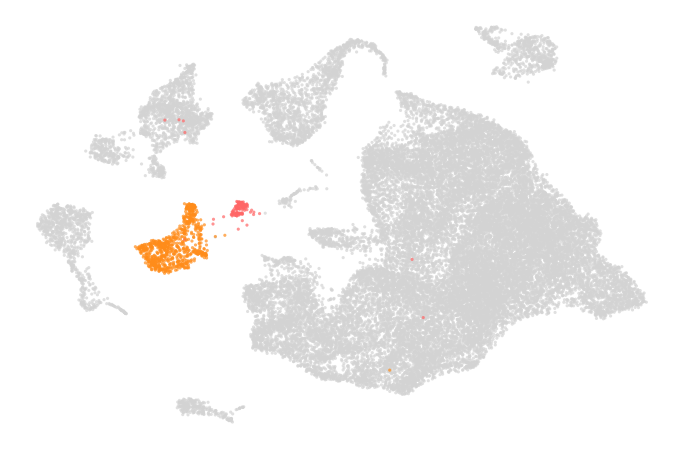

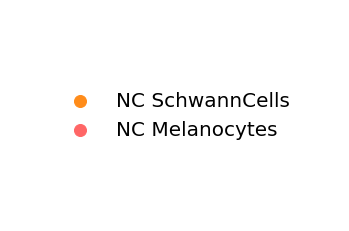

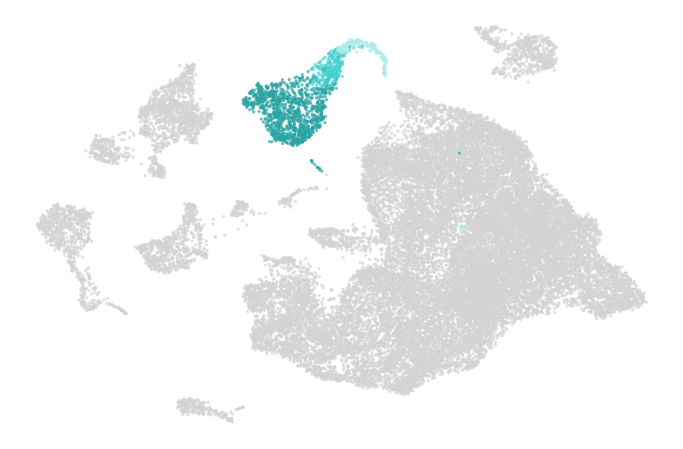

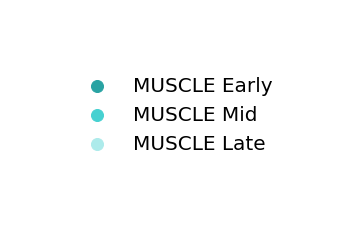

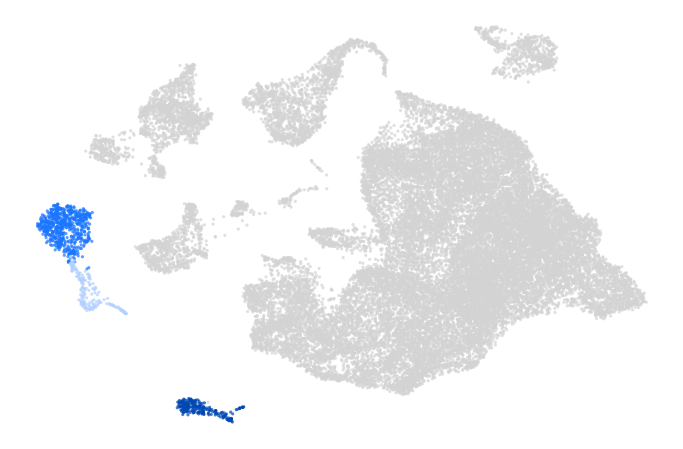

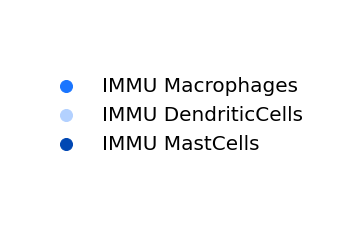

In [59]:
#Highlight other major cell types on top of UMAP
multiplier=2

fig, ax = plt.subplots(figsize = (6*multiplier, 4*multiplier))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 40, title = '', alpha = 0.7,color='HC_named',groups=['VESSEL BECs','VESSEL LECs','VESSEL MuralCells'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Vessel.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":20},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Vessel_Legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

fig, ax = plt.subplots(figsize = (6*multiplier, 4*multiplier))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 40, title = '', alpha = 0.7,color='HC_named',groups=['NC SchwannCells','NC Melanocytes'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Neuro.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":20},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Neuro_Legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

fig, ax = plt.subplots(figsize = (6*multiplier, 4*multiplier))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 40, title = '', alpha = 0.7,color='HC_named',groups=['MUSCLE Early','MUSCLE Mid','MUSCLE Late'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Muscle.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":20},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Muscle_Legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)


fig, ax = plt.subplots(figsize = (6*multiplier, 4*multiplier))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 40, title = '', alpha = 0.7,color='HC_named',groups=['IMMU Macrophages','IMMU DendriticCells','IMMU MastCells'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Immune.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":20},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'ALL_UMAP_Subset_Immune_Legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [60]:
## Calculate age distribution
age_dist = adata.obs[['embryonic_age', 'HC_named']]
age_dist = pd.DataFrame(age_dist.groupby(by = 'HC_named')['embryonic_age'].value_counts().div(age_dist.groupby(by = 'HC_named')['embryonic_age'].count()))
age_dist.columns = ['Fraction']
age_dist = age_dist.reset_index()
age_dist = age_dist.pivot(index = 'HC_named', columns = 'embryonic_age', values = 'Fraction')
age_dist = age_dist.sort_values(by=['E12.5','E13.5'],ascending=False)
age_dist

embryonic_age           E12.5     E13.5     E14.5
HC_named                                         
FIB                  0.385754  0.308973  0.305273
VESSEL BECs          0.346395  0.263323  0.390282
NC Melanocytes       0.307692  0.230769  0.461538
NC SchwannCells      0.276730  0.367296  0.355975
VESSEL LECs          0.240506  0.303797  0.455696
EPI                  0.227273  0.219066  0.553662
IMMU Macrophages     0.224398  0.343373  0.432229
IMMU DendriticCells  0.155000  0.290000  0.555000
IMMU MastCells       0.151020  0.224490  0.624490
MUSCLE Early         0.128000  0.405333  0.466667
MUSCLE Mid           0.095420  0.431298  0.473282
MUSCLE Late          0.090909  0.555024  0.354067
VESSEL MuralCells    0.009804  0.189542  0.800654

In [61]:
#Set order for plotting major cell types
order = ['FIB','EPI','NC SchwannCells','NC Melanocytes','VESSEL BECs','VESSEL LECs','VESSEL MuralCells','IMMU Macrophages','IMMU DendriticCells','IMMU MastCells','MUSCLE Early','MUSCLE Mid','MUSCLE Late']
age_dist = age_dist.loc[order]

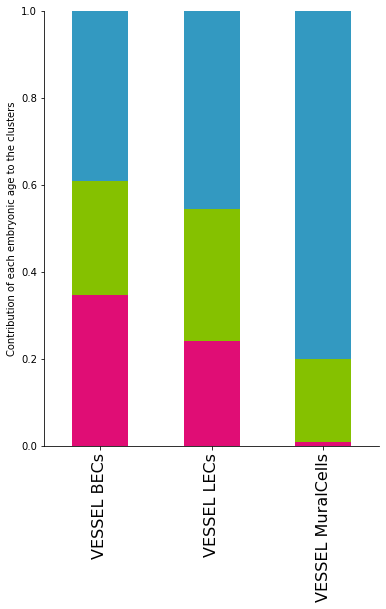

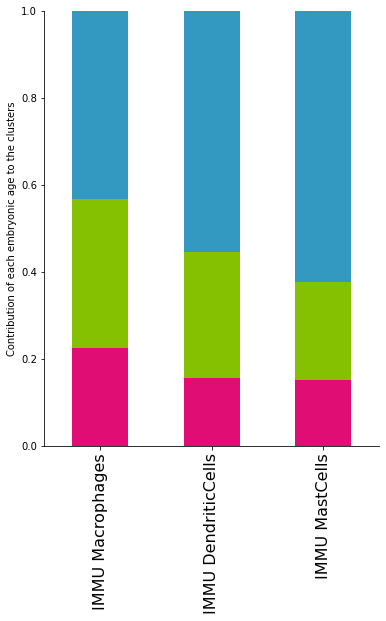

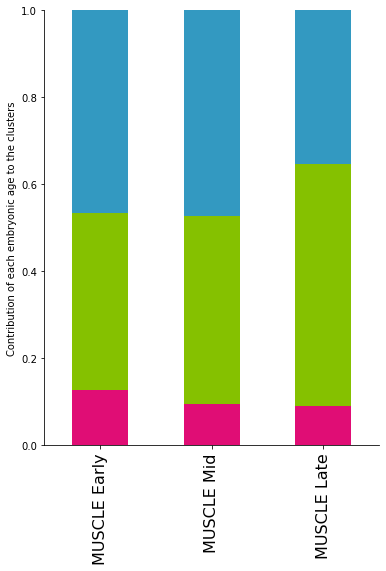

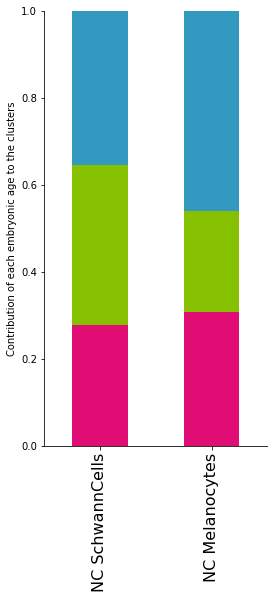

In [62]:
#Plot age distribution of the major cell types (how many cells of each cell type originate from which embryonic age?)
#Note: These plots can be saved with or without labels on x and y axis
cmap = {'E12.5': '#E00D75',
        'E13.5': '#85C100',
        'E14.5': '#3399C1'}

age_dist_sub=age_dist.loc[['VESSEL BECs','VESSEL LECs','VESSEL MuralCells']]
mult=2
fig, ax = plt.subplots(figsize = (3*mult, 4*mult))
age_dist_sub.plot.bar(stacked = True, ax = ax, color = cmap.values())
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize = 16, rotation = 90)  #Comment out if no labels are desired
ax.set_ylabel('Contribution of each embryonic age to the clusters')    #Comment out if no labels are desired
#ax.set_xticklabels([])    #Activate if no labels are desired
#ax.set_yticklabels([])    #Activate if no labels are desired
clear_output()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Subset_Vessel_Age-Contribution_WithLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

age_dist_sub=age_dist.loc[['IMMU Macrophages','IMMU DendriticCells','IMMU MastCells']]
mult=2
fig, ax = plt.subplots(figsize = (3*mult, 4*mult))
age_dist_sub.plot.bar(stacked = True, ax = ax, color = cmap.values())
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize = 16, rotation = 90)  #Comment out if no labels are desired
ax.set_ylabel('Contribution of each embryonic age to the clusters')    #Comment out if no labels are desired
#ax.set_xticklabels([])    #Activate if no labels are desired
#ax.set_yticklabels([])    #Activate if no labels are desired
clear_output()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Subset_Immu_Age-Contribution_WithLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

age_dist_sub=age_dist.loc[['MUSCLE Early','MUSCLE Mid','MUSCLE Late']]
mult=2
fig, ax = plt.subplots(figsize = (3*mult, 4*mult))
age_dist_sub.plot.bar(stacked = True, ax = ax, color = cmap.values())
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize = 16, rotation = 90)  #Comment out if no labels are desired
ax.set_ylabel('Contribution of each embryonic age to the clusters')    #Comment out if no labels are desired
#ax.set_xticklabels([])    #Activate if no labels are desired
#ax.set_yticklabels([])    #Activate if no labels are desired
clear_output()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Subset_Muscle_Age-Contribution_WithLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

age_dist_sub=age_dist.loc[['NC SchwannCells','NC Melanocytes']]
mult=2
fig, ax = plt.subplots(figsize = (2*mult, 4*mult))
age_dist_sub.plot.bar(stacked = True, ax = ax, color = cmap.values())
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize = 16, rotation = 90)  #Comment out if no labels are desired
ax.set_ylabel('Contribution of each embryonic age to the clusters')    #Comment out if no labels are desired
#ax.set_xticklabels([])    #Activate if no labels are desired
#ax.set_yticklabels([])    #Activate if no labels are desired
clear_output()
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Subset_Neuro_Age-Contribution_WithLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

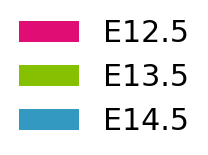

In [63]:
#Plot legend for barplots of age distribution
label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots(figsize = (2, 2))
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":30},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Subset_Age-Contribution_Legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

ax = axes[ix]


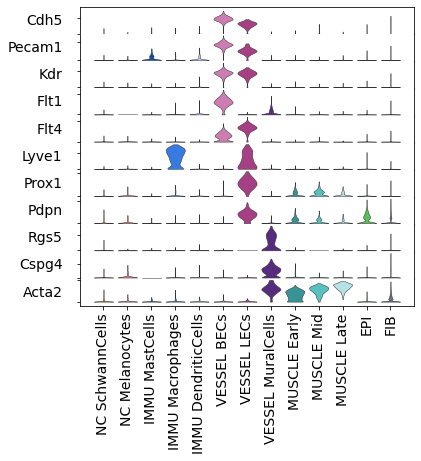

In [64]:
#Plot gene expression across major cell types
#Note: These plots can be saved with or without labels on x and y axis

#Choose one of the four lines below to generate the violin plots in Main Figure 5
marker_genes=['Cdh5','Pecam1','Kdr','Flt1','Flt4','Lyve1','Prox1','Pdpn','Rgs5','Cspg4','Acta2']
#marker_genes=['Actc1','Pax3','Pax7','Myod1','Myf5','Myog','Myf6','Tnnc1','Tnnc2']
#marker_genes=['Sox10','Sox2','Mpz','Gfra2','Ngfr','Npy','Mitf','Dct','Pmel','Mc1r']
#marker_genes=['Ptprc','Adgre1','Itgam','Cx3cr1','Flt3','Cd74','Mertk','Stab1','Kit','Cma1','Tpsb2','Tpsg1']

#Choose one of the nine lines below to generate the violin plots in the Supplmental Figure supplementing Figure 5
#marker_genes=['Efnb2','Ephb4','Apln','Aplnr']
#marker_genes=['Mmp2','Dll4','Notch1','Notch4']
#marker_genes=['Vegfa','Vegfb','Vegfc','Vegfd','Pgf','Pdgfa','Pdgfb','Pdgfc','Bmp2','Bmp7','Tgfb1','Pcolce','Col1a1','Sparc']
#marker_genes=['Pdgfb','Pdgfrb','Hbegf','Egfr']
#marker_genes=['H2-Aa','H2-Ab1','H2-Eb1','Ciita','Itgam','Itgae','Ccr2','Ccr7','Rtn1']
#marker_genes=['Grm6','Prss34','Smpx','Adrb2','Il1rap','C2','Lyz1']
#marker_genes=['Cd3d','Cd3e','Cd3g','Ly6c1']
#marker_genes=['Ntf3','Ntf5','Bdnf','Ngf','Sema3a','Edn1','Edn3','Kit','Kitl','a']
#marker_genes=['Musk','Agrn','Chrna1','Chrna4','Chrnd','Chrng']
#marker_genes=['Sdc1','Sdc2','Sdc3']

cluster_order = ['FIB','EPI','MUSCLE Late','MUSCLE Mid','MUSCLE Early','VESSEL MuralCells','VESSEL LECs','VESSEL BECs','IMMU DendriticCells','IMMU Macrophages','IMMU MastCells','NC Melanocytes','NC SchwannCells'][::-1]
layer = 'normalized'

ncols = 1
mult=3
fig, axes = initialize_subplots(len(marker_genes), ncols = ncols, figsize_multiplier=(6,0.5), gridspec_kw = {'hspace':0.0})

for ix, gene in enumerate(marker_genes):
    ax = axes[ix]
    sc.pl.violin(adata,keys=gene, groupby = 'HC_named', cut = 0, ax = ax, show = False, stripplot = False, linewidth = 0.5, layer = layer, order = cluster_order)
   
    if ix == len(marker_genes)-1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 14)
        ax.spines['top'].set_visible(False)
        ax.set_ylim([-1, ax.get_ylim()[1]])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
        if ix == 0:
            ax.spines['bottom'].set_visible(False)
            ax.set_ylim([0, ax.get_ylim()[1] + 0.1*ax.get_ylim()[1]])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    ax.set_ylabel(gene, fontsize = 14, rotation = 0, labelpad = 10, horizontalalignment='right', verticalalignment='center')   #Activate if labels are desired
    #ax.set_ylabel('')            #Comment out if labels are desired
    #ax.yaxis.set_ticks_position('none')      #Comment out if labels are desired

    ax.set_yticklabels([])      #If no min-max values are desired
    #ax.tick_params(axis = 'y', labelsize = 14)                             #To add min-max values on y axis
    #ax.yaxis.set_major_locator(MaxNLocator(integer = True, nbins = 2))     #To add min-max values on y axis
    #ax.set_yticks([x for x in ax.get_yticks() if x>0][:1])                 #To add min-max values on y axis
    
    ax.set_xlabel('')
    ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1]+0.5)
    #ax.set_xticklabels([])        #Comment out if labels are desired
    
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Vessel_Vln_WithLabels.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

ax = axes[ix]


/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


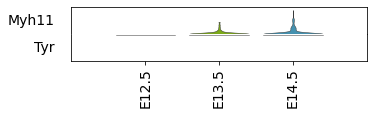

In [65]:
#Optional: Plot gene expression across embryonic age (a cluster of interest can be chosen)

marker_genes=['Myh11','Tyr']
layer = 'normalized'

ncols = 1
mult=3
fig, axes = initialize_subplots(len(marker_genes), ncols = ncols, figsize_multiplier=(5.3,0.5), gridspec_kw = {'hspace':0.0})

for ix, gene in enumerate(marker_genes):
    ax = axes[ix]
    sc.pl.violin(adata[adata.obs['HC_named']=='VESSEL MuralCells'],keys=gene, groupby = 'embryonic_age', cut = 0, ax = ax, show = False, stripplot = False, linewidth = 0.5, layer = layer)
   
    if ix == len(marker_genes)-1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 14)
        ax.spines['top'].set_visible(False)
        ax.set_ylim([-1, ax.get_ylim()[1]])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
        if ix == 0:
            ax.spines['bottom'].set_visible(False)
            ax.set_ylim([0, ax.get_ylim()[1] + 0.1*ax.get_ylim()[1]])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    ax.set_ylabel(gene, fontsize = 14, rotation = 0, labelpad = 10, horizontalalignment='right', verticalalignment='center')   #Activate if labels are desired
    #ax.set_ylabel('')            #Comment out if labels are desired
    ax.yaxis.set_ticks_position('none')      #Comment out if labels are desired

    ax.set_yticklabels([])
    
    ax.set_xlabel('')
    ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1]+0.5)
    #ax.set_xticklabels([])        #Comment out if labels are desired
    
#fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_Genes-across-embryonic-age_Vln_WithLabels.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

# Plotting (Figure S1)

In [66]:
#Assign colors to original samples that match their embryonic age (for plotting purposes)
adata.uns['samples_named_colors']=['#E00D75','#E00D75','#E00D75','#E00D75','#E00D75','#85C100','#85C100','#85C100','#85C100','#85C100','#3399C1','#3399C1','#3399C1','#3399C1','#3399C1']

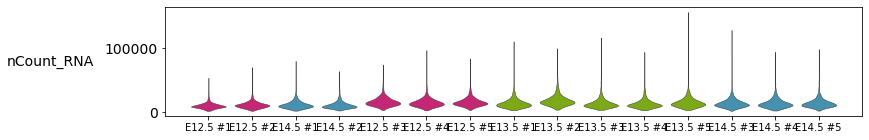

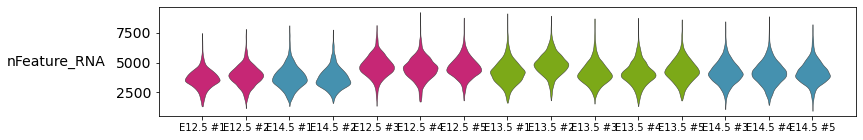

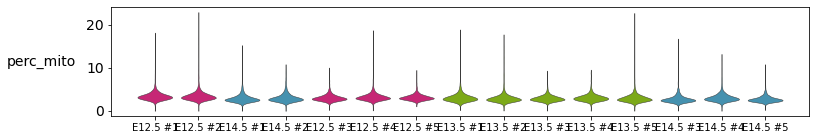

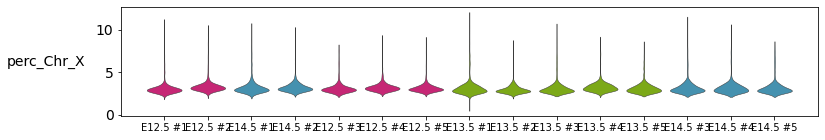

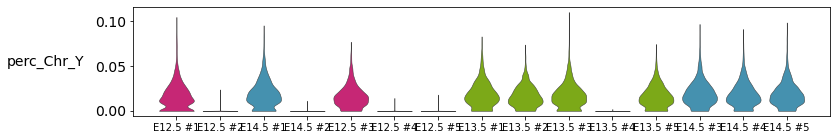

In [67]:
#Plot QC across original samples
#Note: These plots can be saved with or without labels on x and y axis

order=['E12.5 #1','E12.5 #2','E14.5 #1','E14.5 #2','E12.5 #3','E12.5 #4','E12.5 #5','E13.5 #1','E13.5 #2','E13.5 #3','E13.5 #4','E13.5 #5','E14.5 #3','E14.5 #4','E14.5 #5']
features = ['nCount_RNA','nFeature_RNA','perc_mito','perc_Chr_X','perc_Chr_Y']

for feature in features:
    fig, ax = plt.subplots(figsize = (12.5, 2))
    sc.pl.violin(adata, keys = feature, groupby = 'samples_named', ax = ax, cut = 0,order=order,size=0,show = False, stripplot = False, linewidth = 0.5,)
     
    ax.set_ylabel(feature, fontsize = 14, rotation = 0, labelpad = 10, horizontalalignment='right', verticalalignment='center')   #Activate if labels are desired
    #ax.set_ylabel('')            #Comment out if labels are desired

    #ax.set_yticklabels([])                                                  #If no min-max values are desired
    ax.tick_params(axis = 'y', labelsize = 14)                             #To add min-max values on y axis
    
    ax.set_xlabel('')
    ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1]+0.5)
    #ax.set_xticklabels([])        #Comment out if labels are desired
    
    fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_QC_WithLabels{}.pdf'.format(feature)), transparent = True, bbox_inches = 'tight', dpi = 100)

# Plotting (Figure S5)

In [68]:
#Import second level clustering of keratinocytes and fibroblasts; Note that second level clustering was generated in a subsequent step; However it is loaded here for plotting purposes
EPI_2ndlevel = pd.read_csv(os.path.join(path, 'Notebook-Input', 'Epi_2nd-level-clustering.csv'), index_col = 0, sep = ',')
FIB_2ndlevel = pd.read_csv(os.path.join(path, 'Notebook-Input', 'Fib_2nd-level-clustering.csv'), index_col = 0, sep = ',')
EPI_2ndlevel.columns = ['cluster']
FIB_2ndlevel.columns = ['cluster']
cl_2nd = FIB_2ndlevel.append(EPI_2ndlevel)
cl_2nd

cluster
AAACCTGAGACTTGAA_10x_17_033_12     FIB Origin6
AAACCTGAGAGTCTGG_10x_17_033_12     FIB Origin2
AAACCTGAGTATTGGA_10x_17_033_12     FIB Origin6
AAACCTGCACATCCAA_10x_17_033_12     FIB Origin3
AAACCTGCACCGATAT_10x_17_033_12       FIB Deep2
...                                        ...
TGGCCAGTCCTCAATT_10x_17_051_14    EPI Periderm
TGTCCCACAAAGGAAG_10x_17_051_14    EPI Periderm
TTCTCCTTCCAATGGT_10x_17_051_14  EPI BasalTagln
TTTACTGAGATATACG_10x_17_051_14      EPI Basal4
TTTGGTTAGCCACGTC_10x_17_051_14      EPI Basal4

[27528 rows x 1 columns]

In [69]:
cl_2nd.groupby(["cluster"]).apply(len)

cluster
CHOND                 88
EPI Basal1           171
EPI Basal2           283
EPI Basal3           162
EPI Basal4           171
EPI BasalTagln       122
EPI EarlyDiff         69
EPI EarlyPlacode     104
EPI LateDiff          80
EPI LatePlacode      172
EPI Periderm         250
FIB Deep1           1383
FIB Deep2           1164
FIB Deep3           1860
FIB EarlyDC          127
FIB Inter1           812
FIB Inter2           992
FIB Inter3           599
FIB LateDC            71
FIB Lower           1806
FIB Muscle1         1331
FIB Muscle2          695
FIB Origin1          988
FIB Origin2         1063
FIB Origin3         1728
FIB Origin4         1661
FIB Origin5          633
FIB Origin6         2073
FIB Upper1          1550
FIB Upper2          1384
FIB Upper3          2544
FIB Upper4          1392
dtype: int64

In [70]:
#For all cells that have FIB or EPI as their major cell type replace with the second level clustering result
#If no second level clustering result is available for a cell, mark as JUNK (as they were removed at some point during analysis)
tmp = []
for name, cl in adata.obs['HC_named'].items():
    if cl not in ['FIB', 'EPI']:
        tmp.append(cl)
    elif name not in cl_2nd.index:
        tmp.append('JUNK')
    else:
        tmp.append(cl_2nd.loc[name].values[0])
        
adata.obs['subclustering'] = tmp

In [71]:
#Save first level plus second level clustering
cluster_df_sub = pd.DataFrame()
cluster_df_sub['Inferred_Cell_Type'] = adata.obs['subclustering']
cluster_df_sub['Sample_ID'] = cluster_df_sub.index.str[-13:-3]
cluster_df_sub.index.name = 'Cell_Barcode'
cluster_df_sub.to_csv(os.path.join(path, 'Notebook-Output', 'All-Cells_2nd-level-clustering.csv'))
cluster_df_sub

Inferred_Cell_Type   Sample_ID
Cell_Barcode                                                 
AAACCTGAGACTTGAA_10x_17_033_12        FIB Origin6  10x_17_033
AAACCTGAGAGTCTGG_10x_17_033_12        FIB Origin2  10x_17_033
AAACCTGAGTATTGGA_10x_17_033_12        FIB Origin6  10x_17_033
AAACCTGCACATCCAA_10x_17_033_12        FIB Origin3  10x_17_033
AAACCTGCACCGATAT_10x_17_033_12          FIB Deep2  10x_17_033
...                                           ...         ...
TTTGGTTGTGAGCGAT_10x_17_051_14        FIB Origin4  10x_17_051
TTTGTCAAGGGCACTA_10x_17_051_14         FIB Inter3  10x_17_051
TTTGTCACAAGAGTCG_10x_17_051_14         FIB Upper2  10x_17_051
TTTGTCACACAACGTT_10x_17_051_14       MUSCLE Early  10x_17_051
TTTGTCAGTGGCTCCA_10x_17_051_14         FIB Inter3  10x_17_051

[32194 rows x 2 columns]

In [72]:
#Grouping fibroblast/keratinocyte clusters into major fibroblast/keratinocyte groups for plotting purposes
naming_dict = {'EPI Basal1':'EPI Basal1-4','EPI Basal2':'EPI Basal1-4','EPI Basal3':'EPI Basal1-4','EPI Basal4':'EPI Basal1-4','EPI BasalTagln':'EPI BasalTagln',
               'EPI EarlyDiff':'EPI Diff','EPI LateDiff':'EPI Diff','EPI EarlyPlacode':'EPI EarlyPlacode','EPI LatePlacode':'EPI LatePlacode','EPI Periderm':'EPI Periderm',
               'CHOND':'CHOND', 'FIB Deep1':'FIB Deep1-3','FIB Deep2':'FIB Deep1-3','FIB Deep3':'FIB Deep1-3','FIB EarlyDC':'FIB EarlyDC','FIB LateDC':'FIB LateDC',
               'FIB Muscle1':'FIB Muscle1-2', 'FIB Muscle2':'FIB Muscle1-2',  'FIB Lower':'FIB Lower', 'FIB Inter1':'FIB Inter1-3','FIB Inter2':'FIB Inter1-3','FIB Inter3':'FIB Inter1-3',
               'FIB Origin1':'FIB Origin1-6', 'FIB Origin2':'FIB Origin1-6','FIB Origin3':'FIB Origin1-6','FIB Origin4':'FIB Origin1-6','FIB Origin5':'FIB Origin1-6','FIB Origin6':'FIB Origin1-6',
               'FIB Upper1':'FIB Upper1-4', 'FIB Upper2':'FIB Upper1-4','FIB Upper3':'FIB Upper1-4','FIB Upper4':'FIB Upper1-4',
               'IMMU DendriticCells':'IMMU DendriticCells', 'IMMU Macrophages':'IMMU Macrophages', 'IMMU MastCells':'IMMU MastCells',
               'MUSCLE Early':'MUSCLE Early','MUSCLE Mid':'MUSCLE Mid','MUSCLE Late':'MUSCLE Late',
               'NC Melanocytes':'NC Melanocytes', 'NC SchwannCells':'NC SchwannCells',
               'VESSEL BECs':'VESSEL BECs','VESSEL LECs':'VESSEL LECs','VESSEL MuralCells':'VESSEL MuralCells'}
adata.obs['subclustering_grouped'] = [naming_dict[x] for x in adata.obs['subclustering']]
adata.obs['subclustering_grouped'] = adata.obs['subclustering_grouped'].astype('category')

In [73]:
#Grouped clusters as QC
adata.obs['subclustering_grouped'].cat.categories

Index(['CHOND', 'EPI Basal1-4', 'EPI BasalTagln', 'EPI Diff',
       'EPI EarlyPlacode', 'EPI LatePlacode', 'EPI Periderm', 'FIB Deep1-3',
       'FIB EarlyDC', 'FIB Inter1-3', 'FIB LateDC', 'FIB Lower',
       'FIB Muscle1-2', 'FIB Origin1-6', 'FIB Upper1-4', 'IMMU DendriticCells',
       'IMMU Macrophages', 'IMMU MastCells', 'MUSCLE Early', 'MUSCLE Late',
       'MUSCLE Mid', 'NC Melanocytes', 'NC SchwannCells', 'VESSEL BECs',
       'VESSEL LECs', 'VESSEL MuralCells'],
      dtype='object')

In [74]:
#Assign colors for plotting purposes
adata.uns['subclustering_grouped_colors']=['#666699','#47D147','#47D147','#47D147','#47D147','#47D147','#47D147','#666699','#666699','#666699','#666699','#666699','#666699','#666699','#666699', '#B3D1Ff', '#1A75FF', '#0047B3', '#29A3A3', '#ADEBEB', '#47D1D1', '#FF6666', '#FF8c1A', '#DB70B8' , '#B82E8A', '#551F8B']

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'subclustering' as categorical


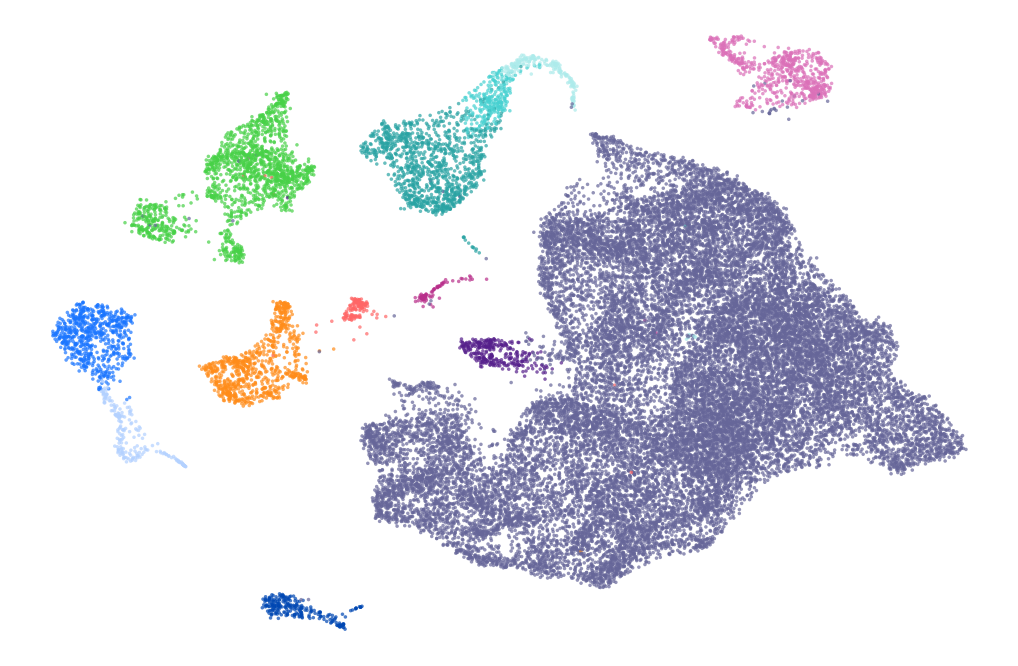

In [75]:
#Plot grouped clusters as QC
multiplier=2
fig, ax = plt.subplots(figsize = (9*multiplier, 6*multiplier))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 50, title = '', alpha = 0.7,color='subclustering_grouped')
ax.legend().remove()

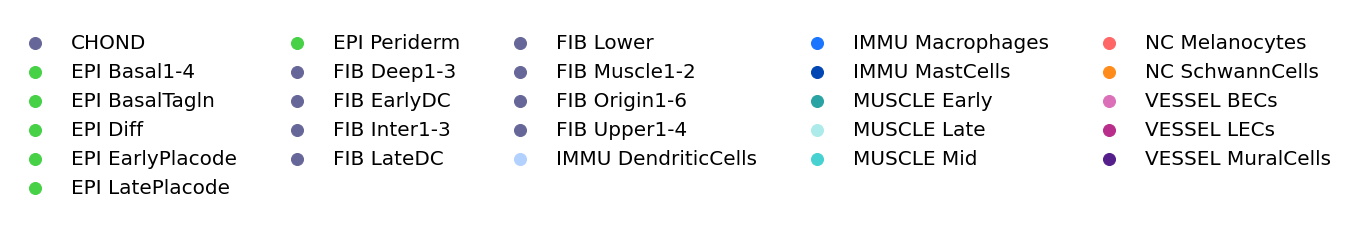

In [76]:
#Plot legend of grouped clusters as QC
label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":20},frameon=False,ncol=5,markerscale=2)

In [77]:
#Calculate z scores for heatmap
adata.layers['zscore'] = sc.pp.scale(adata, copy=True).X

In [78]:
#Pairs Neural Development
left = ['Edn1','Edn3','Gdnf','Ncam1','Nrtn','Psap','Ngf','Bdnf','Nts','Rtn4','Ntf5','Ntf3','App','Npy','Col18a1','Nlgn3','Sema3g','Sema3c','Sema3b','Sema3a','Sema6a','L1cam','Agrn','Adam10','Adam17','Dll1','Dlk1','Psen1','Ptn','Tnc','Mdk','Wnt3a','Kitl','a','Fyn','Bmp2','Bmp4']
right = ['','','','','','Ednrb','Gfra1','Gfra2','Gfra3','Maged1','Ntrk1','Sort1','Ngfr','Adra2a','Gpc1','Gpc4','Nrxn1','Nrxn2','Nrp2','Nrp1','Plxnd1','Plxna2','Plxna4','Ephb2','Musk','Notch1','Ptprz1','Atp6ap2','Kit','Mc1r','Thy1','Acvr2b','','','','','']
pairs = [('Edn1','Ednrb'),('Edn3','Ednrb'),('Gdnf','Ednrb'),('Gdnf','Gfra1'),('Gdnf','Gfra2'),('Gdnf','Gfra3'),('Ncam1','Gfra1'),('Nrtn','Gfra1'),('Nrtn','Gfra2'),('Nrtn','Gfra3'),('Psap','Sort1'),('Ngf','Sort1'),('Bdnf','Sort1'),('Nts','Sort1'),('Ngf','Ntrk1'),('Ngf','Ngfr'),('Bdnf','Ngfr'),('Nts','Ngfr'),('Rtn4','Ngfr'),('Ntf5','Ngfr'),('Ntf3','Ngfr'),('App','Ngfr'),('App','Adra2a'),('Npy','Adra2a'),('App','Gpc1'),('Col18a1','Gpc1'),('Col18a1','Gpc4'),('Nlgn3','Nrxn1'),('Nlgn3','Nrxn2'),('Sema3g','Nrp2'),('Sema3c','Nrp2'),('Sema3c','Nrp1'),('Sema3c','Plxnd1'),('Sema3b','Nrp2'),('Sema3b','Nrp1'),('Sema3a','Plxna2'),('Sema3a','Plxna4'),('Sema6a','Plxna2'),('Sema6a','Plxna4'),('L1cam','Ephb2'),('Agrn','Musk'),('Adam10','Notch1'),('Adam17','Notch1'),('Dll1','Notch1'),('Dlk1','Notch1'),('Psen1','Notch1'),('Ptn','Ptprz1'),('Tnc','Ptprz1'),('Mdk','Ptprz1'),('Wnt3a','Atp6ap2'),('Kitl','Kit'),('a','Mc1r'),('Fyn','Thy1'),('Bmp2','Acvr2b'),('Bmp4','Acvr2b')]

In [79]:
#Calculate group-specific z-scores for neuronal development
df_left = pd.DataFrame(index = left, columns = adata.obs['subclustering_grouped'].cat.categories)
right_tmp = [x if x!=type(int) else ix for ix, x in enumerate(right)]
df_right = pd.DataFrame(index = right_tmp, columns = adata.obs['subclustering_grouped'].cat.categories, data = 0)

for cl in adata.obs['subclustering_grouped'].cat.categories:
    umis = adata.obs[adata.obs['subclustering_grouped'] == cl].index
    df_left[cl] = adata[umis][:, left].layers['zscore'].mean(axis = 0)
    df_right[cl].loc[[x for x in right if x!='']] = adata[umis][:, [x for x in right if x!='']].layers['zscore'].mean(axis = 0)
    
df_left.head()

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


CHOND  EPI Basal1-4  EPI BasalTagln  EPI Diff  EPI EarlyPlacode  \
Edn1  -0.126853      0.319747        0.068598 -0.024675         -0.176063   
Edn3   0.161284     -0.296952        0.485050 -0.422923         -0.393876   
Gdnf  -0.193678     -0.208937       -0.222313 -0.191547         -0.238922   
Ncam1 -0.410325     -1.162735       -1.187595 -1.086339         -1.251527   
Nrtn   0.072556      0.489738        0.899238  0.857250          0.375053   

       EPI LatePlacode  EPI Periderm  FIB Deep1-3  FIB EarlyDC  FIB Inter1-3  \
Edn1         -0.139095      1.981809    -0.088593    -0.120991     -0.009598   
Edn3         -0.420950     -0.354133    -0.145716     2.386464     -0.272713   
Gdnf         -0.186741     -0.146655    -0.107016    -0.268231     -0.167999   
Ncam1        -0.898688     -1.003161     0.251821    -0.238297     -0.600320   
Nrtn          0.291930      3.100695    -0.142679     3.090471     -0.327660   

       ...  IMMU Macrophages  IMMU MastCells  MUSCLE Early  MUSCLE Late  \
Edn1   ...         -0.237085       -0.160620     -0.156931    -0.267338   
Edn3   ...         -0.433972       -0.498224      0.770659     0.115506   
Gdnf   ...         -0.232018       -0.271522      0.009384    -0.219835   
Ncam1  ...         -1.198634       -1.216560     -0.350923     0.380947   
Nrtn   ...         -0.426108       -0.498834     -0.290768    -0.161445   

       MUSCLE Mid  NC Melanocytes  NC SchwannCells  VESSEL BECs  VESSEL LECs  \
Edn1    -0.179514       -0.161840        -0.089856     0.983735    -0.466111   
Edn3     0.317869       -0.480175        -0.472309    -0.341723    -0.161070   
Gdnf    -0.231778        0.316971         1.680725    -0.159159    -0.190065   
Ncam1   -0.327719       -0.964348        -0.410644    -0.885134    -0.842822   
Nrtn    -0.270672       -0.389866        -0.437477    -0.375623    -0.266153   

       VESSEL MuralCells  
Edn1           -0.226780  
Edn3           -0.443181  
Gdnf           -0.247314  
Ncam1          -0.629226  
Nrtn           -0.335251  

[5 rows x 26 columns]

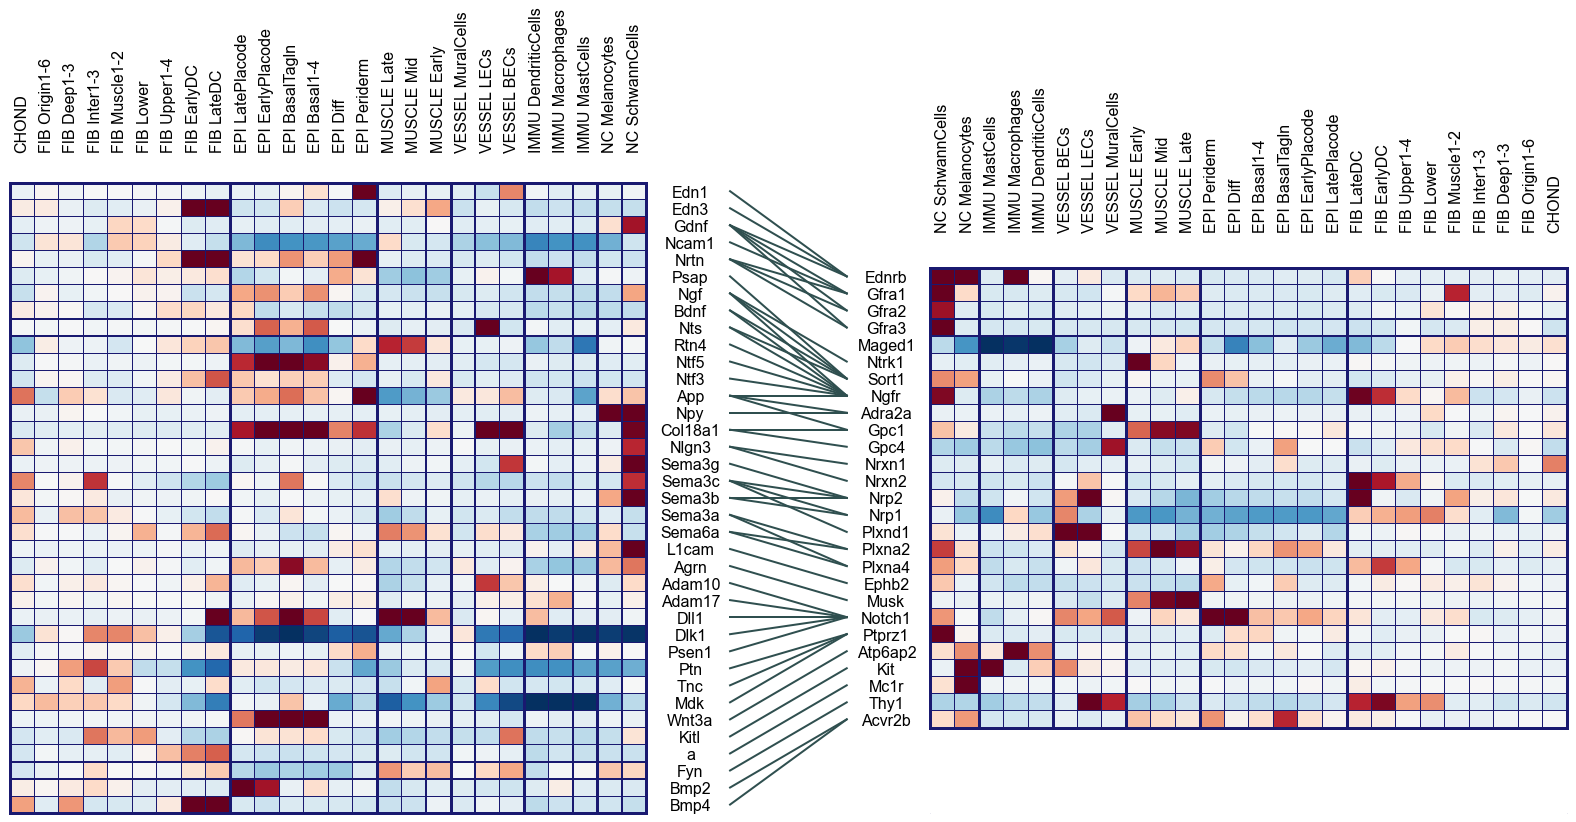

In [80]:
#Plot receptor-ligeand heatmap for Neuoranl Development

wspace = 0.16 #Space between axes
width_ratios = [5, 1, 5] #width ratios for axes
palette = 'RdBu_r'
fontsize = 16

#Change font
prop = fm.FontProperties(fname=os.path.join(path, 'Notebook-Input','arial.ttf'))

mult = 2
ncols = 3
fig, axes = plt.subplots(figsize = (2*7*mult, 5.83*mult), ncols = ncols, gridspec_kw = {'wspace': wspace, 'width_ratios': width_ratios})

ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]

#Plot heatmaps
col_order_left = ['CHOND','FIB Origin1-6','FIB Deep1-3','FIB Inter1-3','FIB Muscle1-2','FIB Lower','FIB Upper1-4','FIB EarlyDC','FIB LateDC','EPI LatePlacode','EPI EarlyPlacode','EPI BasalTagln','EPI Basal1-4','EPI Diff','EPI Periderm','MUSCLE Late','MUSCLE Mid','MUSCLE Early','VESSEL MuralCells','VESSEL LECs','VESSEL BECs','IMMU DendriticCells','IMMU Macrophages','IMMU MastCells','NC Melanocytes','NC SchwannCells']
col_order_right = col_order_left[::-1]
sbn.heatmap(data = df_left[col_order_left], ax = ax0, vmin=-2, vmax=2, cmap=palette, linewidth = 0.1, linecolor = 'midnightblue', cbar = False, )
sbn.heatmap(data = df_right[col_order_right], ax = ax2, vmin=-2, vmax=2, cmap=palette, linewidth = 0.1, linecolor = 'midnightblue', cbar = False, mask = df_right == 0)

#Plot lines
for pair in pairs:
    ixl = np.where(np.array(left) == pair[0])[0]
    ixr = np.where(np.array(right) == pair[1])[0]
    x = ax0.get_yticks()[::-1][ixl]
    y = ax2.get_yticks()[::-1][ixr]
    try:
        ax1.plot((x, y), c = 'darkslategrey', ls = '-', lw = 2)
    except ValueError:
        print(pair)
    
#Make y-axes same
ylim = ax0.get_ylim()
ax1.set_ylim(ylim[::-1])
ax2.set_ylim(ylim)

#Hide line plot borders and ticks
[ax1.spines[spine].set_visible(False) for spine in ax.spines]
ax1.set_xticks([])
ax1.set_yticks([])

#Move heatmap yticks to right side
ax0.yaxis.tick_right()

#Move xticks to top
ax0.xaxis.tick_top()
ax0.tick_params(direction='out', pad=25, axis = 'x', rotation = 90) #Move left heatmap tick labels a bit farther away (otherways gray background overlaps black line)
ax2.xaxis.tick_top()
ax2.tick_params(direction='out', pad=-55, axis = 'x', rotation = 90) #Move right heatmap tick labels closer to the heatmap

#Mask "empty" heatmap cells on the right heatmap
pad = 4.97 #Quite specific to not overlap the gridline but still hide everything else
p1 = mpl.patches.Polygon([[0,-1], [np.ceil(ax2.get_xticks().max()),-1], [np.ceil(ax2.get_xticks().max()), pad], [0, pad]], closed = True, color = 'w')
p2 = mpl.patches.Polygon([[0,np.ceil(ax2.get_yticks().max())], [np.ceil(ax2.get_xticks().max()),np.ceil(ax2.get_yticks().max())], [np.ceil(ax2.get_xticks().max()),np.ceil(ax2.get_yticks().max()) - pad], [0,np.ceil(ax2.get_yticks().max()) - pad]], closed = True, color = 'w')
ax2.add_patch(p1)
ax2.add_patch(p2)

#Modify ticklabels
[x.set_font(prop) for ax in [ax0, ax2] for x in ax.get_yticklabels()] #Change font for every label on the y-axis
[x.set_font(prop) for ax in [ax0, ax2] for x in ax.get_xticklabels()] #Change font for every label on the x-axis
ax0.set_yticklabels(ax0.get_yticklabels(), rotation = 0, fontsize = fontsize, ha = 'center') # Change alignment and fontsizes for y tick labels
ax2.set_yticklabels(ax2.get_yticklabels(), rotation = 0, fontsize = fontsize, ha = 'center')
ax2.set_yticks(ax2.get_yticks()[5:-5]) #Hide the empty tick labels for the right heatmap
[ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize, ) for ax in [ax0, ax2]] #Change fontsize for x tick labels
[ax.tick_params(direction='out', pad=38, axis = 'y') for ax in [ax0, ax2]] #Move y tick labels closer to lines
[ax.xaxis.set_ticks_position('none') for ax in [ax0, ax2]]
[ax.yaxis.set_ticks_position('none') for ax in [ax0, ax2]]

#Make frames for groups
edgecolor = 'midnightblue'
linewidth = 3
#Change x and y limits to make the boxes look nicer
pad = 0.1
[ax.set_xlim([ax.get_xlim()[0]-pad, ax.get_xlim()[1]+pad]) for ax in [ax0, ax2]]
[ax.set_ylim([ax.get_ylim()[0]+pad, ax.get_ylim()[1]-pad]) for ax in [ax0, ax2]]
ax1.set_ylim([ax1.get_ylim()[0]-pad, ax1.get_ylim()[1]+pad])

#Make boxes around specific columns. The columns that should be in the box can be specified here [start, n_cols].
#Left
cols = [[0,9],[9,6],[15,3],[18,3],[21,3],[24,2]]
for ix, (start, n_cols) in enumerate(cols):
    start
    top = 0
    end = (start + n_cols) if (start + n_cols) == (len(cols)-1) else (start + n_cols)
    bottom = np.ceil(ax0.get_yticks()[-1])
    ax0.add_patch(mpl.patches.Polygon([[start, top], [end, top], [end, bottom], [start, bottom]], closed = True, fill = False, ec = edgecolor, lw = linewidth))

#Right
cols = [[0,2],[2,3],[5,3],[8,3],[11,6],[17,9]]
for ix, (start, n_cols) in enumerate(cols):
    top = 5
    end = (start + n_cols) if (start + n_cols) == (len(cols)-1) else (start + n_cols)
    bottom = np.ceil(ax2.get_yticks()[-1])
    ax2.add_patch(mpl.patches.Polygon([[start, top], [end, top], [end, bottom], [start, bottom]], closed = True, fill = False, ec = edgecolor, lw = linewidth))

clear_output(wait = True)
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_RecLigHeatmap_NeuronalDevelopment.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [81]:
#Pairs immune cell recruitment
left = ['Ccl2','Ccl3','Ccl4','Ccl6','Ccl7','Ccl9','Ccl11','Ccl12','Ccl24','Il16','Il18','Ebi3','Il6','Il4','Il13','Tslp','Ltb','Tnf','Cd14','Icam1','Icam2','Icam4','Lyz2','Hp','Selplg','Cfh','B2m','Cd86','Fyn','Vcam1','Pkm','Mdk','Jam3','Spon2','Cyr61','Ly86','Tgfb1','Cd200','Alox5ap','Gas6','Mrc1','Cd47','Irak4','Madcam1','Clec11a','Kitl','Pecam1','Adam17','Bgn','Lgals1','Sema6d']
right = ['','Ccr1','Ccr2','Ccr5','Cd48','Il6st','Il6ra','Cd53','Il4ra','Il13ra1','Il2rg','Il17rc','Ltbr','Tnfrsf21','Ripk1','Cav1','Spn','Itga4','Itgal','Esam','Itgb2','Klrd1','Tfrc','Itgam','Cd3g','Cd28','Cd44','Cd180','Cd200r1','Alox5','Mertk','Ptprc','Sirpa','Tlr7','Thy1','Msn','Itgb7','Cd109','Tgfbr2','Tgfbr1','Smad3','Kit','Cd38','Notch1','Ly96','Tlr2','Tlr1','Cd69','Trem2','Tyrobp','']
pairs = [('Ccl2','Ccr1'),('Ccl2','Ccr2'),('Ccl2','Ccr5'),('Ccl3','Ccr1'),('Ccl3','Ccr5'),('Ccl4','Ccr1'),('Ccl4','Ccr5'),('Ccl6','Ccr1'),('Ccl7','Ccr1'),('Ccl7','Ccr2'),('Ccl7','Ccr5'),('Ccl9','Ccr1'),('Ccl11','Ccr2'),('Ccl12','Ccr1'),('Ccl12','Ccr2'),('Ccl12','Ccr5'),('Ccl24','Ccr2'),('Ccl24','Ccr5'),('Il16','Ccr5'),('Il18','Cd48'),('Il6','Il6ra'),('Il4','Cd53'),('Il4','Il4ra'),('Il4','Il13ra1'),('Il4','Il2rg'),('Il13','Il4ra'),('Il13','Il13ra1'),('Il13','Il2rg'),('Ltb','Ltbr'),('Tnf','Ltbr'),('Tnf','Ripk1'),('Cd14','Ripk1'),('Cd14','Itga4'),('Cd14','Itgb2'),('Icam1','Il2rg'),('Icam1','Spn'),('Icam1','Itgal'),('Icam1','Itgb2'),('Icam1','Itgam'),('Icam2','Itgal'),('Icam2','Itgb2'),('Icam2','Itgam'),('Icam4','Itga4'),('Icam4','Itgal'),('Icam4','Itgb2'),('Icam4','Itgam'),('Lyz2','Itgal'),('Hp','Itgb2'),('Hp','Itgam'),('Selplg','Itgb2'),('Selplg','Esam'),('Selplg','Itgam'),('Cfh','Itgam'),('B2m','Klrd1'),('B2m','Tfrc'),('B2m','Cd3g'),('Cd86','Cd28'),('Pkm','Cd44'),('Ly86','Cd180'),('Cd200','Cd200r1'),('Alox5ap','Alox5'),('Gas6','Mertk'),('Mrc1','Ptprc'),('Cd47','Sirpa'),('Irak4','Tlr7'),('Tnf','Tnfrsf21'),('Icam1','Cav1'),('Fyn','Spn'),('Fyn','Thy1'),('Ebi3','Il6st'),('Il6','Il6st'),('Madcam1','Cd44'),('Madcam1','Itga4'),('Madcam1','Itgb7'),('Mdk','Itga4'),('Spon2','Itgam'),('Spon2','Itgb2'),('Jam3','Itgb2'),('Cyr61','Itgam'),('Cyr61','Itgb2'),('Tgfb1','Cav1'),('Tgfb1','Cd109'),('Tgfb1','Tgfbr2'),('Tgfb1','Tgfbr1'),('Tgfb1','Smad3'),('Tslp','Il17rc'),('Kitl','Kit'),('Clec11a','Kit'),('Pecam1','Cd38'),('Adam17','Notch1'),('Bgn','Ly96'),('Bgn','Tlr2'),('Bgn','Tlr1'),('Lgals1','Cd69'),('Lgals1','Ptprc'),('Vcam1','Msn'),('Vcam1','Itga4'),('Vcam1','Itgb2'),('Vcam1','Itgb7'),('Sema6d','Tyrobp'),('Sema6d','Trem2')]

In [82]:
#Calculate group-specific z-scores for immune cell recruitment
df_left = pd.DataFrame(index = left, columns = adata.obs['subclustering_grouped'].cat.categories)
right_tmp = [x if x!=type(int) else ix for ix, x in enumerate(right)]
df_right = pd.DataFrame(index = right_tmp, columns = adata.obs['subclustering_grouped'].cat.categories, data = 0)

for cl in adata.obs['subclustering_grouped'].cat.categories:
    umis = adata.obs[adata.obs['subclustering_grouped'] == cl].index
    df_left[cl] = adata[umis][:, left].layers['zscore'].mean(axis = 0)
    df_right[cl].loc[[x for x in right if x!='']] = adata[umis][:, [x for x in right if x!='']].layers['zscore'].mean(axis = 0)
    
df_left.head()

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


CHOND  EPI Basal1-4  EPI BasalTagln  EPI Diff  EPI EarlyPlacode  \
Ccl2 -0.188830     -0.234598       -0.237784 -0.250163         -0.234250   
Ccl3 -0.113016     -0.131611       -0.111272 -0.150677         -0.118679   
Ccl4 -0.079615     -0.083572       -0.066012 -0.095917         -0.018484   
Ccl6 -0.087304     -0.064545       -0.079823 -0.045567         -0.019621   
Ccl7 -0.136053     -0.170551       -0.156297 -0.150584         -0.158563   

      EPI LatePlacode  EPI Periderm  FIB Deep1-3  FIB EarlyDC  FIB Inter1-3  \
Ccl2        -0.230598     -0.241969    -0.018124    -0.211919     -0.138455   
Ccl3        -0.121197     -0.127685    -0.082110    -0.092925     -0.128888   
Ccl4        -0.072185     -0.063635    -0.053047    -0.057689     -0.092621   
Ccl6        -0.011980     -0.084180    -0.082518    -0.125350     -0.115440   
Ccl7        -0.155107     -0.183499     0.114357    -0.172462      0.024272   

      ...  IMMU Macrophages  IMMU MastCells  MUSCLE Early  MUSCLE Late  \
Ccl2  ...          2.641848       -0.261147     -0.334920    -0.419460   
Ccl3  ...          3.438664        0.487204     -0.124911    -0.130358   
Ccl4  ...          2.161596        0.193270     -0.060816    -0.089426   
Ccl6  ...          2.173832        0.145406     -0.097952    -0.124808   
Ccl7  ...          2.666383       -0.164564     -0.179402    -0.263554   

      MUSCLE Mid  NC Melanocytes  NC SchwannCells  VESSEL BECs  VESSEL LECs  \
Ccl2   -0.328496       -0.274998        -0.240233    -0.275477    -0.462140   
Ccl3   -0.116516       -0.138819        -0.119784    -0.144277    -0.139849   
Ccl4   -0.096382       -0.095832        -0.059730    -0.068892     0.043960   
Ccl6   -0.114375       -0.047447         0.156717    -0.085650    -0.055724   
Ccl7   -0.185029       -0.180525        -0.160678    -0.281944    -0.284254   

      VESSEL MuralCells  
Ccl2           2.414983  
Ccl3          -0.116183  
Ccl4          -0.090221  
Ccl6          -0.044367  
Ccl7          -0.059109  

[5 rows x 26 columns]

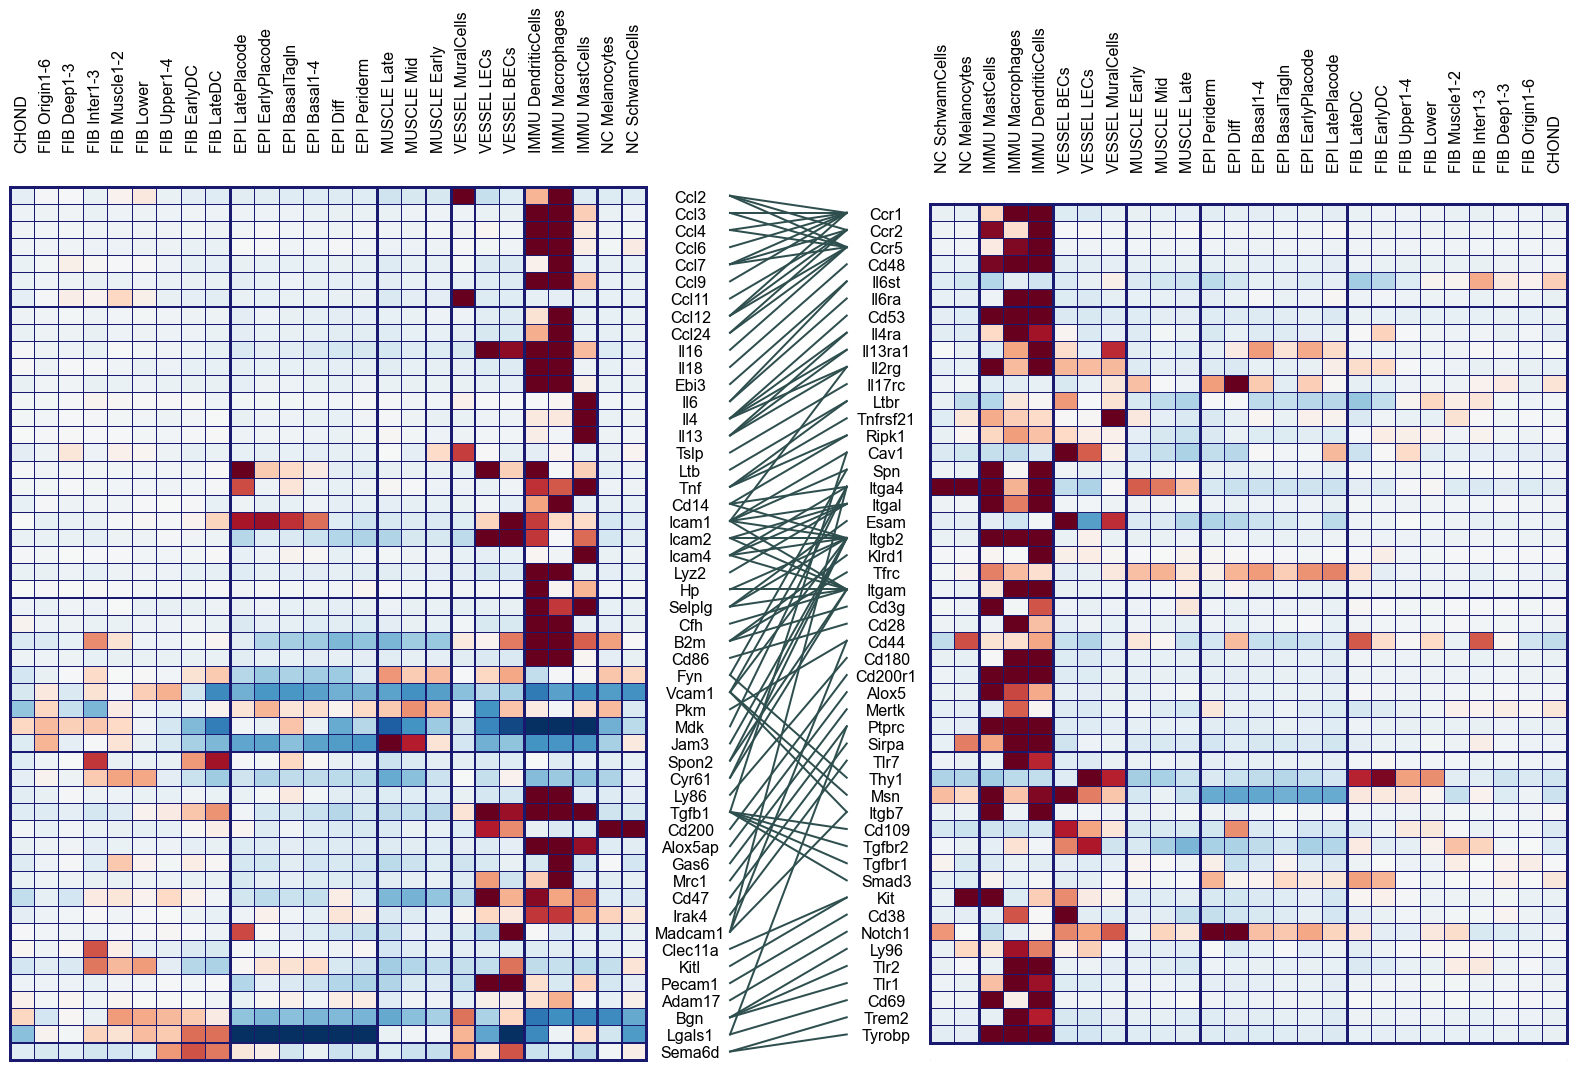

In [83]:
#Plot receptor-ligeand heatmap for Immune Cell Recruitment

wspace = 0.16 #Space between axes
width_ratios = [5, 1, 5] #width ratios for axes
palette = 'RdBu_r'
fontsize = 16

#Change font
prop = fm.FontProperties(fname=os.path.join(path, 'Notebook-Input','arial.ttf'))

mult = 2
ncols = 3
fig, axes = plt.subplots(figsize = (2*7*mult, 8.06*mult), ncols = ncols, gridspec_kw = {'wspace': wspace, 'width_ratios': width_ratios})

ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]

#Plot heatmaps
#col_order_left = df_left.columns
col_order_left = ['CHOND','FIB Origin1-6','FIB Deep1-3','FIB Inter1-3','FIB Muscle1-2','FIB Lower','FIB Upper1-4','FIB EarlyDC','FIB LateDC','EPI LatePlacode','EPI EarlyPlacode','EPI BasalTagln','EPI Basal1-4','EPI Diff','EPI Periderm','MUSCLE Late','MUSCLE Mid','MUSCLE Early','VESSEL MuralCells','VESSEL LECs','VESSEL BECs','IMMU DendriticCells','IMMU Macrophages','IMMU MastCells','NC Melanocytes','NC SchwannCells']
col_order_right = col_order_left[::-1]
sbn.heatmap(data = df_left[col_order_left], ax = ax0, vmin=-2, vmax=2, cmap=palette, linewidth = 0.1, linecolor = 'midnightblue', cbar = False, )
sbn.heatmap(data = df_right[col_order_right], ax = ax2, vmin=-2, vmax=2, cmap=palette, linewidth = 0.1, linecolor = 'midnightblue', cbar = False, mask = df_right == 0)

#Plot lines
for pair in pairs:
    ixl = np.where(np.array(left) == pair[0])[0]
    ixr = np.where(np.array(right) == pair[1])[0]
    x = ax0.get_yticks()[::-1][ixl]
    y = ax2.get_yticks()[::-1][ixr]
    try:
        ax1.plot((x, y), c = 'darkslategrey', ls = '-', lw = 2)
    except ValueError:
        print(pair)
    
#Make y-axes same
ylim = ax0.get_ylim()
ax1.set_ylim(ylim[::-1])
ax2.set_ylim(ylim)

#Hide line plot borders and ticks
[ax1.spines[spine].set_visible(False) for spine in ax.spines]
ax1.set_xticks([])
ax1.set_yticks([])

#Move heatmap yticks to right side
ax0.yaxis.tick_right()

#Move xticks to top
ax0.xaxis.tick_top()
ax0.tick_params(direction='out', pad=30, axis = 'x', rotation = 90) #Move left heatmap tick labels a bit farther away (otherways gray background overlaps black line)

ax2.xaxis.tick_top()
ax2.tick_params(direction='out', pad=10, axis = 'x', rotation = 90) #Move right heatmap tick labels closer to the heatmap

#Mask "empty" heatmap cells on the right heatmap
pad = 0.93 #Quite specific to not overlap the gridline but still hide everything else
p1 = mpl.patches.Polygon([[0,-1], [np.ceil(ax2.get_xticks().max()),-1], [np.ceil(ax2.get_xticks().max()), pad], [0, pad]], closed = True, color = 'w')
p2 = mpl.patches.Polygon([[0,np.ceil(ax2.get_yticks().max())], [np.ceil(ax2.get_xticks().max()),np.ceil(ax2.get_yticks().max())], [np.ceil(ax2.get_xticks().max()),np.ceil(ax2.get_yticks().max()) - pad], [0,np.ceil(ax2.get_yticks().max()) - pad]], closed = True, color = 'w')
ax2.add_patch(p1)
ax2.add_patch(p2)

#Modify ticklabels
[x.set_font(prop) for ax in [ax0, ax2] for x in ax.get_yticklabels()] #Change font for every label on the y-axis
[x.set_font(prop) for ax in [ax0, ax2] for x in ax.get_xticklabels()] #Change font for every label on the x-axis
ax0.set_yticklabels(ax0.get_yticklabels(), rotation = 0, fontsize = fontsize, ha = 'center') # Change alignment and fontsizes for y tick labels
ax2.set_yticklabels(ax2.get_yticklabels(), rotation = 0, fontsize = fontsize, ha = 'center')
ax2.set_yticks(ax2.get_yticks()[1:-1]) #Hide the empty tick labels for the right heatmap
[ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize, ) for ax in [ax0, ax2]] #Change fontsize for x tick labels
[ax.tick_params(direction='out', pad=38, axis = 'y') for ax in [ax0, ax2]] #Move y tick labels closer to lines
[ax.xaxis.set_ticks_position('none') for ax in [ax0, ax2]]
[ax.yaxis.set_ticks_position('none') for ax in [ax0, ax2]]

#Make frames for groups
edgecolor = 'midnightblue'
linewidth = 3
#Change x and y limits to make the boxes look nicer
pad = 0.1
[ax.set_xlim([ax.get_xlim()[0]-pad, ax.get_xlim()[1]+pad]) for ax in [ax0, ax2]]
[ax.set_ylim([ax.get_ylim()[0]+pad, ax.get_ylim()[1]-pad]) for ax in [ax0, ax2]]
ax1.set_ylim([ax1.get_ylim()[0]-pad, ax1.get_ylim()[1]+pad])

#Make boxes around specific columns. The columns that should be in the box can be specified here [start, n_cols].
#Left
cols = [[0,9],[9,6],[15,3],[18,3],[21,3],[24,2]]
for ix, (start, n_cols) in enumerate(cols):
    start
    top = 0
    end = (start + n_cols) if (start + n_cols) == (len(cols)-1) else (start + n_cols)
    bottom = np.ceil(ax0.get_yticks()[-1])
    ax0.add_patch(mpl.patches.Polygon([[start, top], [end, top], [end, bottom], [start, bottom]], closed = True, fill = False, ec = edgecolor, lw = linewidth))

#Right
cols = [[0,2],[2,3],[5,3],[8,3],[11,6],[17,9]]
for ix, (start, n_cols) in enumerate(cols):
    top = 1
    end = (start + n_cols) if (start + n_cols) == (len(cols)-1) else (start + n_cols)
    bottom = np.ceil(ax2.get_yticks()[-1])
    ax2.add_patch(mpl.patches.Polygon([[start, top], [end, top], [end, bottom], [start, bottom]], closed = True, fill = False, ec = edgecolor, lw = linewidth))

clear_output(wait = True)
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_RecLigHeatmap_ImmuneCellRecruitment.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [84]:
#Pairs Angiogenesis
left = ['Apln','Sema4a','Sema3e','Sema3g','Fgf7','Pgf','Vegfb','Vegfc','Pdgfc','Fn1','Vtn','Sema6d','Col18a1','Col4a1','Hspg2','Hgf','Lamb2','Jam3','Adam9','Vcan','Timp2','Mdk','Tnc','Thbs1','Thbs2','Dll1','Dll4','Dlk1','Jag1','Nov','Psen1','Adam10','Efna1','Efna3','Efna4','Efna5','Efnb1','Efnb2','Adm','Pdgfb','Pdgfa','Mfge8','Angpt2','Angpt1','Angptl1','Angptl2','Angptl4','Tgfb2','Bmp2','Bmp7','Edn1','Hbegf']
right = ['','','','','','','','','','','Aplnr','Plxnd1','Nrp1','Nrp2','Flt1','Flt4','Itga5','Lyve1','Kdr','Robo4','Itgb1','Ptprb','Cd36','Notch4','Notch3','Notch1','Pecam1','Epha2','Epha3','Epha4','Epha5','Epha7','Ephb1','Ephb2','Gpr182','S1pr1','Pdgfrb','Tek','Tie1','Eng','Adgrl4','Egfr','','','','','','','','','','']
pairs = [('Apln','Aplnr'),('Sema4a','Plxnd1'),('Sema3e','Plxnd1'),('Sema3e','Nrp1'),('Sema3g','Nrp2'),('Fgf7','Nrp1'),('Pgf','Nrp1'),('Pgf','Nrp2'),('Pgf','Flt1'),('Vegfb','Nrp1'),('Vegfb','Flt1'),('Vegfc','Nrp2'),('Vegfc','Flt1'),('Vegfc','Flt4'),('Vegfc','Lyve1'),('Vegfc','Kdr'),('Vegfc','Itgb1'),('Pdgfc','Flt1'),('Pdgfc','Flt4'),('Pdgfc','Kdr'),('Fn1','Flt4'),('Fn1','Itgb1'),('Fn1','Robo4'),('Vtn','Kdr'),('Vtn','Itgb1'),('Sema6d','Kdr'),('Col18a1','Kdr'),('Col18a1','Itgb1'),('Col4a1','Itgb1'),('Hspg2','Itgb1'),('Hgf','Itgb1'),('Lamb2','Itgb1'),('Jam3','Itgb1'),('Adam9','Itgb1'),('Vcan','Itgb1'),('Timp2','Itgb1'),('Mdk','Itgb1'),('Mdk','Ptprb'),('Tnc','Itgb1'),('Tnc','Ptprb'),('Thbs1','Itgb1'),('Thbs1','Cd36'),('Thbs2','Itgb1'),('Thbs2','Cd36'),('Thbs2','Notch3'),('Thbs2','Notch4'),('Dll1','Notch1'),('Dll1','Notch3'),('Dll1','Notch4'),('Dll4','Notch1'),('Dll4','Notch3'),('Dll4','Notch4'),('Jag1','Notch1'),('Jag1','Notch3'),('Jag1','Notch4'),('Nov','Notch1'),('Psen1','Notch1'),('Psen1','Notch3'),('Psen1','Notch4'),('Adam10','Notch1'),('Adam10','Epha3'),('Efna1','Epha2'),('Efna1','Epha3'),('Efna1','Epha4'),('Efna1','Epha5'),('Efna1','Epha7'),('Efna1','Ephb2'),('Efna3','Epha2'),('Efna3','Ephb1'),('Efna4','Epha2'),('Efna5','Epha2'),('Efna5','Ephb1'),('Efnb1','Ephb1'),('Efnb2','Epha3'),('Efnb2','Epha4'),('Efnb2','Ephb1'),('Efnb2','Ephb2'),('Efnb2','Pecam1'),('Adm','Gpr182'),('Pdgfb','S1pr1'),('Angpt2','Tek'),('Angpt2','Tie1'),('Angpt1','Itgb1'),('Angpt1','Tek'),('Angpt2','Tie1'),('Angptl1','Tek'),('Angptl2','Tie1'),('Angptl4','Tie1'),('Tgfb2','Eng'),('Edn1','Adgrl4'),('Bmp2','Eng'),('Bmp7','Eng'),('Pdgfb','Pdgfrb'),('Pdgfa','Pdgfrb'),('Mfge8','Pdgfrb'),('Hbegf','Egfr'),('Vtn','Itga5'),('Col18a1','Itga5')]

In [85]:
#Calculate group-specific z-scores for immune cell recruitment
df_left = pd.DataFrame(index = left, columns = adata.obs['subclustering_grouped'].cat.categories)
right_tmp = [x if x!=type(int) else ix for ix, x in enumerate(right)]
df_right = pd.DataFrame(index = right_tmp, columns = adata.obs['subclustering_grouped'].cat.categories, data = 0)

for cl in adata.obs['subclustering_grouped'].cat.categories:
    umis = adata.obs[adata.obs['subclustering_grouped'] == cl].index
    df_left[cl] = adata[umis][:, left].layers['zscore'].mean(axis = 0)
    df_right[cl].loc[[x for x in right if x!='']] = adata[umis][:, [x for x in right if x!='']].layers['zscore'].mean(axis = 0)
    
df_left.head()

/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/user/anaconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


CHOND  EPI Basal1-4  EPI BasalTagln  EPI Diff  EPI EarlyPlacode  \
Apln   -0.208961     -0.356793       -0.329746 -0.408929         -0.282901   
Sema4a  0.043992      1.010386        0.689921  1.591019          0.940304   
Sema3e  0.348089      0.250076        0.839789 -0.072254          0.176204   
Sema3g -0.140186     -0.213770       -0.038757 -0.272110         -0.176527   
Fgf7   -0.520083     -0.215989       -0.231266 -0.177253         -0.266141   

        EPI LatePlacode  EPI Periderm  FIB Deep1-3  FIB EarlyDC  FIB Inter1-3  \
Apln          -0.382461     -0.407887    -0.111915    -0.221663      0.195402   
Sema4a         0.872871      0.242898     0.004780    -0.149658     -0.038098   
Sema3e         0.587112      1.936109     0.094830    -0.033462      0.463933   
Sema3g        -0.277812     -0.295080    -0.098314    -0.029279     -0.117139   
Fgf7          -0.153957     -0.308267    -0.103455    -0.474760      1.060625   

        ...  IMMU Macrophages  IMMU MastCells  MUSCLE Early  MUSCLE Late  \
Apln    ...         -0.369554       -0.303251     -0.335171    -0.531638   
Sema4a  ...          0.782202        0.860429     -0.181554    -0.185292   
Sema3e  ...         -0.187274       -0.114649      0.002129     0.146488   
Sema3g  ...         -0.191709       -0.131980     -0.071983    -0.221587   
Fgf7    ...         -0.365621       -0.202985     -0.240063    -0.202567   

        MUSCLE Mid  NC Melanocytes  NC SchwannCells  VESSEL BECs  VESSEL LECs  \
Apln     -0.371343       -0.304664        -0.279074     3.425483    -0.698113   
Sema4a   -0.158515       -0.180202        -0.199352    -0.306804    -0.284507   
Sema3e    0.023793        0.007366        -0.017365    -0.270360    -0.260263   
Sema3g   -0.119548        0.168193         2.848166     1.422052    -0.383952   
Fgf7     -0.334103       -0.267200        -0.286830    -0.381897    -0.356082   

        VESSEL MuralCells  
Apln            -0.434362  
Sema4a           0.070859  
Sema3e          -0.172505  
Sema3g          -0.197104  
Fgf7            -0.293788  

[5 rows x 26 columns]

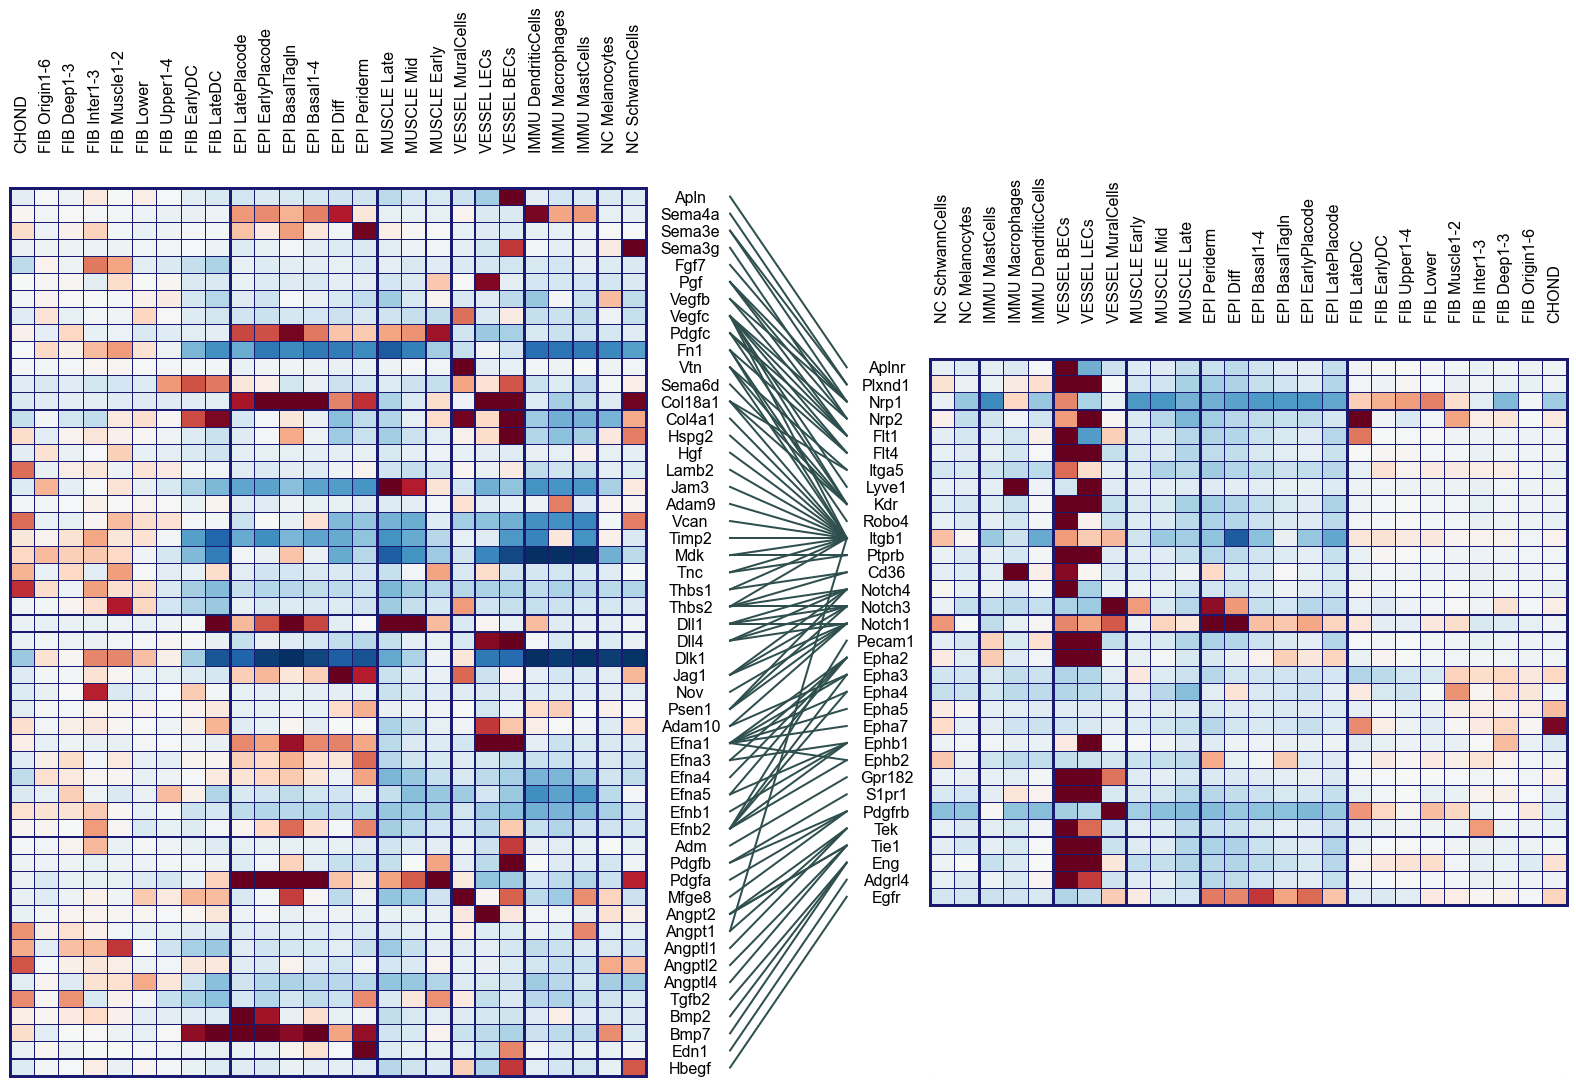

In [86]:
#Plot receptor-ligeand heatmap for Angiogenesis

wspace = 0.16 #Space between axes
width_ratios = [5, 1, 5] #width ratios for axes
palette = 'RdBu_r'
fontsize = 16

#Change font
prop = fm.FontProperties(fname=os.path.join(path, 'Notebook-Input','arial.ttf'))

mult = 2
ncols = 3
fig, axes = plt.subplots(figsize = (2*7*mult, 8.2*mult), ncols = ncols, gridspec_kw = {'wspace': wspace, 'width_ratios': width_ratios})

ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]

#Plot heatmaps
#col_order_left = df_left.columns
col_order_left = ['CHOND','FIB Origin1-6','FIB Deep1-3','FIB Inter1-3','FIB Muscle1-2','FIB Lower','FIB Upper1-4','FIB EarlyDC','FIB LateDC','EPI LatePlacode','EPI EarlyPlacode','EPI BasalTagln','EPI Basal1-4','EPI Diff','EPI Periderm','MUSCLE Late','MUSCLE Mid','MUSCLE Early','VESSEL MuralCells','VESSEL LECs','VESSEL BECs','IMMU DendriticCells','IMMU Macrophages','IMMU MastCells','NC Melanocytes','NC SchwannCells']
col_order_right = col_order_left[::-1]
sbn.heatmap(data = df_left[col_order_left], ax = ax0, vmin=-2, vmax=2, cmap=palette, linewidth = 0.1, linecolor = 'midnightblue', cbar = False, )
sbn.heatmap(data = df_right[col_order_right], ax = ax2, vmin=-2, vmax=2, cmap=palette, linewidth = 0.1, linecolor = 'midnightblue', cbar = False, mask = df_right == 0)

#Plot lines
for pair in pairs:
    ixl = np.where(np.array(left) == pair[0])[0]
    ixr = np.where(np.array(right) == pair[1])[0]
    x = ax0.get_yticks()[::-1][ixl]
    y = ax2.get_yticks()[::-1][ixr]
    try:
        ax1.plot((x, y), c = 'darkslategrey', ls = '-', lw = 2)
    except ValueError:
        print(pair)
    
#Make y-axes same
ylim = ax0.get_ylim()
ax1.set_ylim(ylim[::-1])
ax2.set_ylim(ylim)

#Hide line plot borders and ticks
[ax1.spines[spine].set_visible(False) for spine in ax.spines]
ax1.set_xticks([])
ax1.set_yticks([])

#Move heatmap yticks to right side
ax0.yaxis.tick_right()

#Move xticks to top
ax0.xaxis.tick_top()
ax0.tick_params(direction='out', pad=30, axis = 'x', rotation = 90) #Move left heatmap tick labels a bit farther away (otherways gray background overlaps black line)

ax2.xaxis.tick_top()
ax2.tick_params(direction='out', pad=-140, axis = 'x', rotation = 90) #Move right heatmap tick labels closer to the heatmap

#Mask "empty" heatmap cells on the right heatmap
pad = 10 #Quite specific to not overlap the gridline but still hide everything else
p1 = mpl.patches.Polygon([[0,-1], [np.ceil(ax2.get_xticks().max()),-1], [np.ceil(ax2.get_xticks().max()), pad], [0, pad]], closed = True, color = 'w')
pad = 10
p2 = mpl.patches.Polygon([[0,np.ceil(ax2.get_yticks().max())], [np.ceil(ax2.get_xticks().max()),np.ceil(ax2.get_yticks().max())], [np.ceil(ax2.get_xticks().max()),np.ceil(ax2.get_yticks().max()) - pad], [0,np.ceil(ax2.get_yticks().max()) - pad]], closed = True, color = 'w')
ax2.add_patch(p1)
ax2.add_patch(p2)

#Modify ticklabels
[x.set_font(prop) for ax in [ax0, ax2] for x in ax.get_yticklabels()] #Change font for every label on the y-axis
[x.set_font(prop) for ax in [ax0, ax2] for x in ax.get_xticklabels()] #Change font for every label on the x-axis
ax0.set_yticklabels(ax0.get_yticklabels(), rotation = 0, fontsize = fontsize, ha = 'center') # Change alignment and fontsizes for y tick labels
ax2.set_yticklabels(ax2.get_yticklabels(), rotation = 0, fontsize = fontsize, ha = 'center')
ax2.set_yticks(ax2.get_yticks()[5:-5]) #Hide the empty tick labels for the right heatmap
[ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize, ) for ax in [ax0, ax2]] #Change fontsize for x tick labels
[ax.tick_params(direction='out', pad=38, axis = 'y') for ax in [ax0, ax2]] #Move y tick labels closer to lines
[ax.xaxis.set_ticks_position('none') for ax in [ax0, ax2]]
[ax.yaxis.set_ticks_position('none') for ax in [ax0, ax2]]

#Make frames for groups
edgecolor = 'midnightblue'
linewidth = 3
#Change x and y limits to make the boxes look nicer
pad = 0.1
[ax.set_xlim([ax.get_xlim()[0]-pad, ax.get_xlim()[1]+pad]) for ax in [ax0, ax2]]
[ax.set_ylim([ax.get_ylim()[0]+pad, ax.get_ylim()[1]-pad]) for ax in [ax0, ax2]]
ax1.set_ylim([ax1.get_ylim()[0]-pad, ax1.get_ylim()[1]+pad])

#Make boxes around specific columns. The columns that should be in the box can be specified here [start, n_cols].
#Left
cols = [[0,9],[9,6],[15,3],[18,3],[21,3],[24,2]]
for ix, (start, n_cols) in enumerate(cols):
    start
    top = 0
    end = (start + n_cols) if (start + n_cols) == (len(cols)-1) else (start + n_cols)
    bottom = np.ceil(ax0.get_yticks()[-1])
    ax0.add_patch(mpl.patches.Polygon([[start, top], [end, top], [end, bottom], [start, bottom]], closed = True, fill = False, ec = edgecolor, lw = linewidth))

#Right
cols = [[0,2],[2,3],[5,3],[8,3],[11,6],[17,9]]
for ix, (start, n_cols) in enumerate(cols):
    top = 10
    end = (start + n_cols) if (start + n_cols) == (len(cols)-1) else (start + n_cols)
    bottom = np.ceil(ax2.get_yticks()[-6])
    ax2.add_patch(mpl.patches.Polygon([[start, top], [end, top], [end, bottom], [start, bottom]], closed = True, fill = False, ec = edgecolor, lw = linewidth))

clear_output(wait = True)
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_RecLigHeatmap_Angiogenesis.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

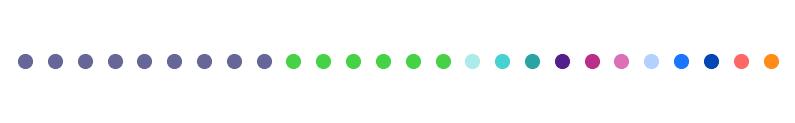

In [87]:
#Generate color legend for clusters in heatmap
mult = 2
fig, ax = plt.subplots(figsize = (7*mult, 2))
xlim = ax0.get_xlim()
xlab = ax0.get_xticklabels()
colors = adata.uns['subclustering_grouped_colors']
colors = [colors[i] for i in [7,8,9,10,11,12,13,14,0,6,1,2,3,4,5,19,20,18,25,24,23,15,16,17,21,22]]
#colors_left = colors[6:14,0:]
for ix, xl in enumerate(xlab):
    ax.scatter(x = xl.get_position()[0], y = 1, color = colors[ix], marker = list(mpl.lines.Line2D.markers.keys())[2], s = 200)
[ax.spines[spine].set_visible(False) for spine in ax.spines]
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(xlim)

fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_RecLigHeatmap_Colordots.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

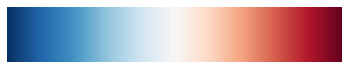

In [88]:
#Generate legend for heatmap
fig, ax = plt.subplots(figsize=(6, 2))
fig.subplots_adjust(bottom=0.5)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.RdBu_r,
                                orientation='horizontal')
cb1.set_ticks([])
cb1.outline.set_visible(False)
fig.savefig(os.path.join(path, 'Notebook-Output', 'ALL_RecLig_DoubleHeatmap_Colorbar.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

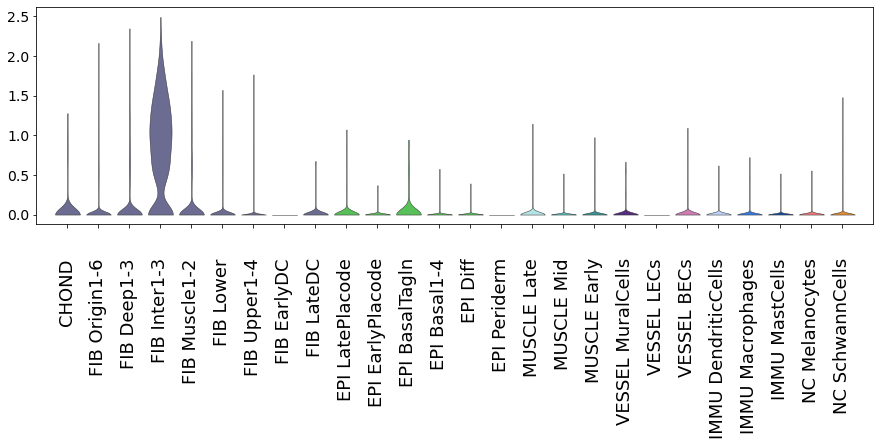

In [89]:
#Optional: Plot expression of a single gene across all major cell types ()
features = ['Gata6']

for feature in features:
    fig, ax = plt.subplots(figsize = (15, 4))
    sc.pl.violin(adata, keys = feature, groupby = 'subclustering_grouped', ax = ax, layer='normalized',cut = 0,size=0,show = False, stripplot = False, linewidth = 0.5,order = ['CHOND','FIB Origin1-6','FIB Deep1-3','FIB Inter1-3','FIB Muscle1-2','FIB Lower','FIB Upper1-4','FIB EarlyDC','FIB LateDC','EPI LatePlacode','EPI EarlyPlacode','EPI BasalTagln','EPI Basal1-4','EPI Diff','EPI Periderm','MUSCLE Late','MUSCLE Mid','MUSCLE Early','VESSEL MuralCells','VESSEL LECs','VESSEL BECs','IMMU DendriticCells','IMMU Macrophages','IMMU MastCells','NC Melanocytes','NC SchwannCells'])
     
    ax.set_ylabel(feature, fontsize = 14, rotation = 0, labelpad = 10, horizontalalignment='right', verticalalignment='center')   #Activate if labels are desired
    ax.set_ylabel('')            #Comment out if labels are desired

    #ax.set_yticklabels([])                                                  #If no min-max values are desired
    ax.tick_params(axis = 'y', labelsize = 14)                             #To add min-max values on y axis
    
    ax.tick_params(axis = 'x', labelsize = 18,rotation=90,pad=30) 
    ax.set_xlabel('')
    ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1]+0.5)
    #ax.set_xticklabels([])        #Comment out if labels are desired
    #ax.set_xticklabels([])        #Comment out if labels are desired
    
    fig.savefig(os.path.join(path, 'Notebook-Output','ALL_Expression_WithLabels{}.pdf'.format(feature)), transparent = True, bbox_inches = 'tight', dpi = 100)

# Save adata object as h5ad

In [90]:
adata.write_h5ad(os.path.join(path, 'Notebook-Output', 'Adata-object_{}.h5'.format(cell_type)))